In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
#import hurst
#from hurst import compute_Hc, random_walk
from itertools import combinations
import json
import requests
import time
import warnings
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
warnings.filterwarnings('ignore')

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()
#Speeding up the computation

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
da_1=pd.DataFrame()
st = datetime.datetime(2021, 5, 15 , 0, 0)
en = datetime.datetime(2022, 6, 15, 0, 0)
coin=['BTC','UNI','SUSHI','CRV','SOL','MANA','COMP','DOGE','BAT','MATIC','ENJ','XMR','LINK','BCH','XLM','ADA','BNB','LTC','ETH']
#encoding= 'latin-1'
#coin=['ETH','MATIC']
j=1
for i in tqdm(coin):
    da=pd.read_pickle('C:\\Users\\91626\\Work\\project\\Quant Res\\Stat Arbitrage\\'+str(i)+'.pkl')
    da=da[st:en]
    da_1[i]=(da.groupby(pd.Grouper(freq='5Min')).agg({"open": "first","close": "last","low": "min","high": "max"})['close'])

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  5.96it/s]


In [ ]:
da_1.fillna(method='bfill',inplace=True)

In [ ]:
st = datetime.datetime(2021, 5, 15 , 0, 0)
en_mid = datetime.datetime(2022, 1, 3, 0, 0)
da1= da_1[st:en_mid]

In [ ]:
#Calculate average annual percentage return and volatilities
returns = pd.DataFrame(da1.pct_change().mean() * 252*12*24)
#print(returns)
returns.columns = ['Returns']
returns['Volatility'] = da1.pct_change().std() * np.sqrt(252*12*24)
data=returns
data

,Returns,Volatility
BTC,0.214439,0.744450
UNI,-0.136912,1.203723
SUSHI,0.197192,1.414620
CRV,1.681345,1.514657
SOL,2.593672,1.457858
MANA,2.277921,1.585379
COMP,-0.687499,1.207874
DOGE,-0.354496,1.343001
BAT,0.868177,1.268085
MATIC,1.963510,1.680681


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(data)
rescaledDataset = pd.DataFrame(scaler.fit_transform(data),columns = data.columns, index = data.index)
X=rescaledDataset
X.head(2)


,Returns,Volatility
BTC,-0.329012,-2.224939
UNI,-0.693517,-0.221602


In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold


## K-Means

In [ ]:
from sklearn.cluster import KMeans
inertia=[]
seed=42

for k in tqdm(range(2,16)):#max loop=16
    kmeans= KMeans(n_clusters=k,random_state=seed,n_jobs=-1,verbose=True)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    #print(inertia[-1])

100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 115.86it/s]

Initialization complete
Iteration 0, inertia 10.951519789123155.
Initialization complete
Iteration 1, inertia 10.951519789123155.
Initialization complete
Iteration 2, inertia 10.951519789123155.
Initialization complete
Iteration 3, inertia 10.951519789123155.
Initialization complete
Iteration 4, inertia 10.951519789123155.
Initialization complete
Iteration 5, inertia 10.951519789123155.
Initialization complete
Iteration 6, inertia 10.951519789123155.
Initialization complete
Iteration 7, inertia 10.951519789123155.
Initialization complete
Iteration 8, inertia 10.951519789123155.
Initialization complete
Iteration 9, inertia 10.951519789123155.
Initialization complete
Iteration 0, inertia 6.176307685464961.
Initialization complete
Iteration 1, inertia 6.659119956538463.
Initialization complete
Iteration 2, inertia 6.176307685464961.
Initialization complete
Iteration 3, inertia 6.176307685464961.
Initialization complete
Iteration 4, inertia 6.659119956538463.
Initialization complete
Iterat

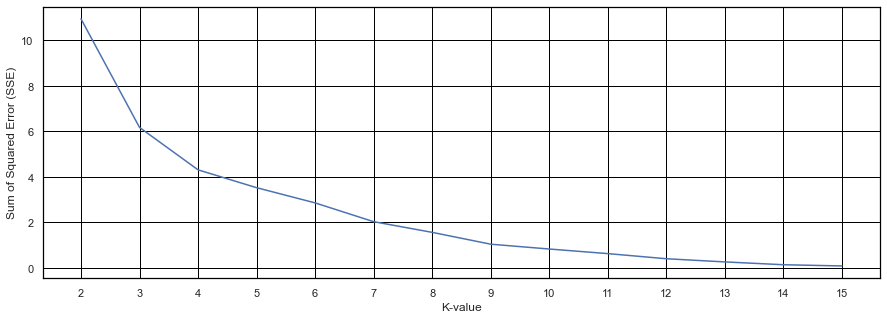

In [ ]:
#Elbow method
plt.figure(figsize=(15, 5))
sns.set(rc={'axes.facecolor':'white','axes.edgecolor':'black'})
plt.plot(range(2, 16),inertia)
plt.xticks([i for i in range(2, 16)])
plt.xlabel('K-value')
plt.ylabel('Sum of Squared Error (SSE)')
plt.grid(True,color='black')

#Range of k-value = {6,7,8}

In [ ]:
#Silhouette Score Method
from sklearn import metrics

silhouette_score = []
for k in tqdm(range(2,19)):  #Max 19 cant exceed n_samples-1 (19 coins)

    kmeans= KMeans(n_clusters=k,random_state=seed,n_jobs=-1)
    kmeans.fit(X)
    silhouette= metrics.silhouette_score(X, kmeans.labels_,random_state=10)
    silhouette_score.append(silhouette)
    #print(silhouette)

100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 162.39it/s]


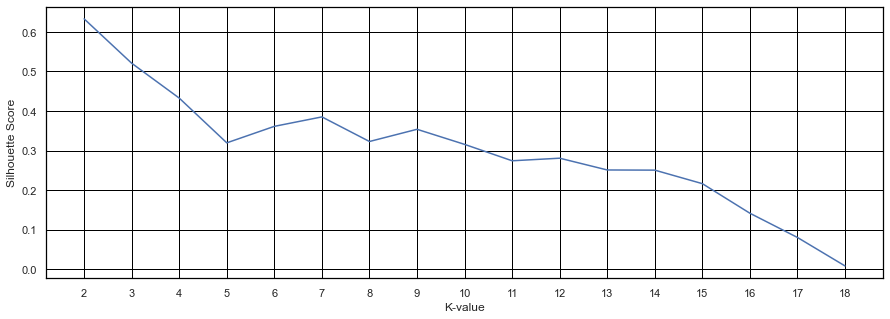

In [ ]:
plt.figure(figsize=(15, 5))
sns.set(rc={'axes.facecolor':'white','axes.edgecolor':'black'})
plt.plot(range(2, 19),silhouette_score)
plt.xticks([i for i in range(2, 19)])
plt.xlabel('K-value')
plt.ylabel('Silhouette Score')
plt.grid(True,color='black')
#Range of k-value={6,7,8}
#Range of k can be calculated through krish naik video.

Considering both tests taking k=6 (as 6 has more silhouette score than 7)

In [ ]:
n_clusters1=5
k_means= KMeans(n_clusters= n_clusters1,n_jobs=-1,random_state=seed)
k_means.fit(X)
target_labels= k_means.predict(X)
print(target_labels)
centroids = k_means.cluster_centers_
print(centroids)

[2 4 1 3 0 0 4 1 1 3 3 4 1 4 4 1 2 4 2]
[[ 1.9755081   1.16505136]
 [-0.35015692  0.18859435]
 [-0.22101539 -1.53342004]
 [ 1.21603994  1.38111247]
 [-0.86421754 -0.46935863]]


In [ ]:
cluster_labels1= k_means.labels_
#cluister_labels1

Text(0, 0.5, 'Annualized Volatility')

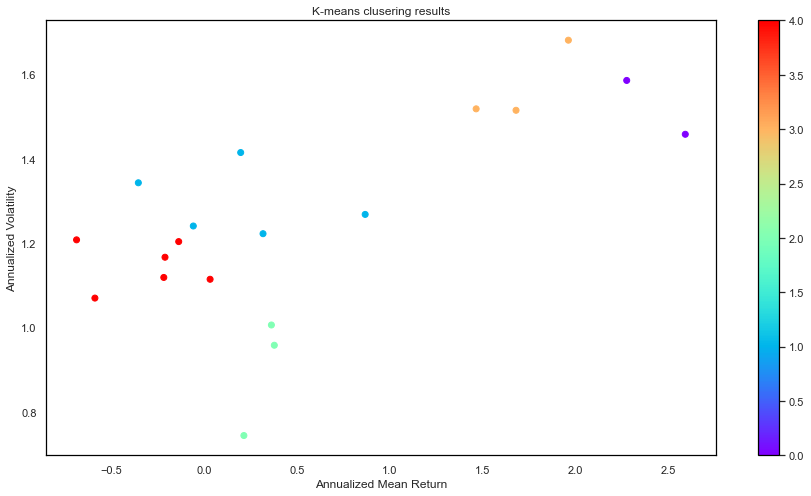

In [ ]:
#centroids[:,0]
#centroids[:,:1]
plt.figure(figsize=(15,8))
sns.set(rc={'axes.facecolor':'white','axes.edgecolor':'black'})
#plt.scatter(centroids[:,0],centroids[:,1],marker='*',linewidth=4)
#plt.scatter(X.iloc[:,0],X.iloc[:,1],c=cluster_labels1,cmap ="rainbow")
plt.scatter(data.iloc[:,0],data.iloc[:,1],c=cluster_labels1,cmap ="rainbow")
plt.colorbar()
plt.grid(True)
plt.title('K-means clusering results')
plt.xlabel('Annualized Mean Return')
plt.ylabel('Annualized Volatility')

In [ ]:
clustered_series1 = pd.Series(index= X.index, data= k_means.labels_)

In [ ]:
clustered_series1[clustered_series1==1]

SUSHI    1
DOGE     1
BAT      1
LINK     1
ADA      1
dtype: int32

In [ ]:
clustered_series1.value_counts()

4    6
1    5
2    3
3    3
0    2
dtype: int64

In [ ]:
#plt.barh(clustered_series.value_counts(), width=range(0,len(clustered_series)))

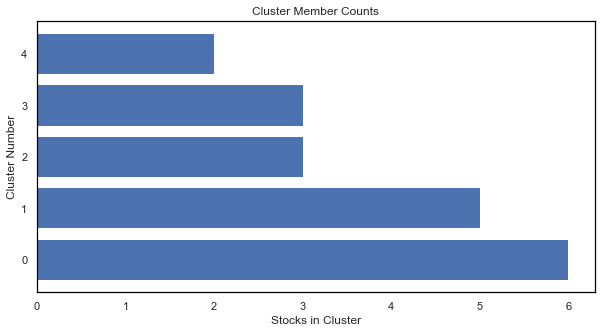

In [ ]:
#showing number of stocks in each cluster
#sns.set(rc={'axes.facecolor':'white','axes.edgecolor':'black'})
clustered_series = pd.Series(index=X.index, data=k_means.labels_)

plt.figure(figsize=(10,5))
plt.barh(range(len(clustered_series1.value_counts())),clustered_series1.value_counts())
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

## Agglomerative clustering

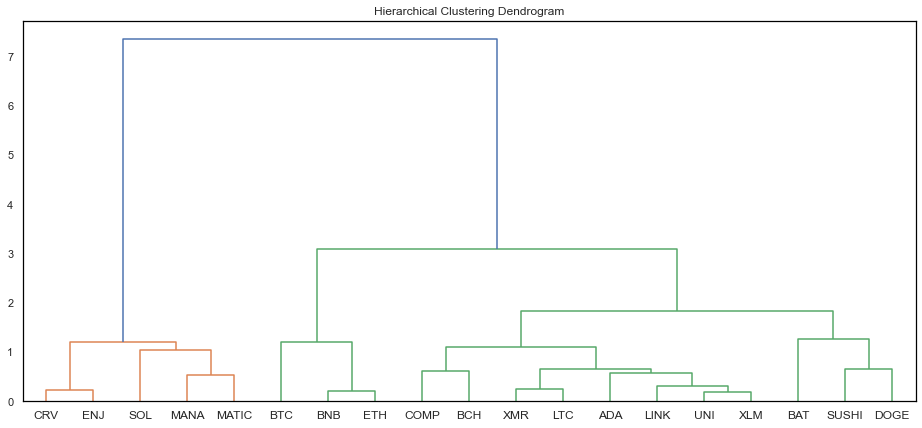

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, ward

def plot_dendrogram(Y,model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    '''
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    '''
    linkage_matrix=linkage(X, method='ward')
    # Plot the corresponding dendrogram
    plt.figure(figsize=(16,7))
    plt.title("Hierarchical Clustering Dendrogram")
    dendrogram(linkage_matrix,labels = Y.index, **kwargs)
    return linkage_matrix


#iris = load_iris()
#X = iris.data
#Y=[[12,13],[15,25],[17,30]]
#Y=[[12,13,19],[15,25,17],[21,20,16],[12,78,1000]]
# setting distance_threshold=0 ensures we compute the full tree.
agglomerative = AgglomerativeClustering(n_clusters=None,distance_threshold=0)

agglomerative = agglomerative.fit(X)
# plot the top three levels of the dendrogram
linkage_matrix=plot_dendrogram(X,agglomerative, truncate_mode="level", p=30)
sns.set(rc={'axes.facecolor':'white','axes.edgecolor':'black'})
#plt.xlabel("Number of points in node (or index of point if no parenthesis).")

In [ ]:
distance_threshold = 1.5
clusters = fcluster(linkage_matrix, distance_threshold, criterion='distance')
#The fcluster() method forms flat clusters from the hierarchical clustering.
#This hierarchical clustering is defined by the given linkage matrix, identifying a link between clustered classes.
chosen_clusters = pd.Series(data=clusters,index= X.index)
np.sort(chosen_clusters.unique())

array([1, 2, 3, 4])

In [ ]:
n_clusters2=6
agglomerative= AgglomerativeClustering(n_clusters=n_clusters2, affinity = 'euclidean', linkage = 'ward')
cluster_labels2 = agglomerative.fit_predict(X)

In [ ]:
clustered_series2 = pd.Series(index= X.index, data= cluster_labels2)
np.sort(clustered_series2.unique())

array([0, 1, 2, 3, 4, 5], dtype=int64)

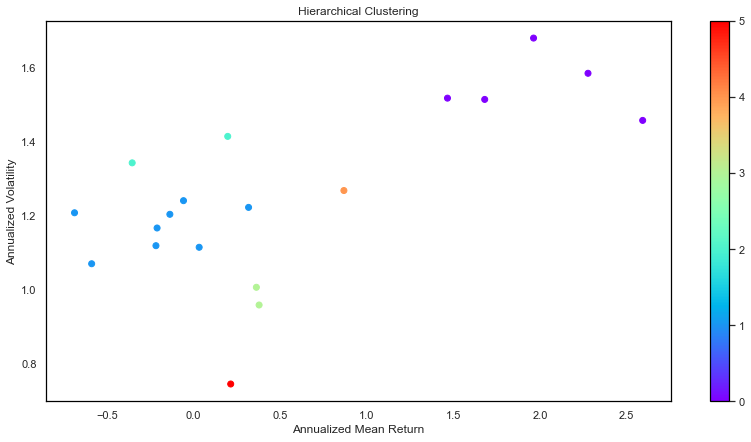

In [ ]:
plt.figure(figsize=(14,7))
sns.set(rc={'axes.facecolor':'white','axes.edgecolor':'black'})
#plt.scatter(X.iloc[:,0],X.iloc[:,1], c =cluster_labels2,cmap='rainbow')
plt.scatter(data.iloc[:,0],data.iloc[:,1], c =cluster_labels2,cmap='rainbow')
plt.title('Hierarchical Clustering')
plt.xlabel('Annualized Mean Return')
plt.ylabel('Annualized Volatility')
plt.colorbar()

## Affinity Propagation

In [ ]:
for i in tqdm(range(5,35)):
    affine = AffinityPropagation(random_state=seed,damping=0.5,convergence_iter=i,verbose=True)
    affine.fit(X)
    silhouette= metrics.silhouette_score(X,affine.predict(X),random_state=10)
    print(">> Silhouette Score at {0} is {1}% ".format(i,np.round(silhouette*100,3)))


 83%|███████████████████████████████████████████████████████████████████▌             | 25/30 [00:00<00:00, 124.24it/s]

Converged after 11 iterations.
>> Silhouette Score at 5 is 52.082% 
Converged after 12 iterations.
>> Silhouette Score at 6 is 52.082% 
Converged after 13 iterations.
>> Silhouette Score at 7 is 52.082% 
Converged after 14 iterations.
>> Silhouette Score at 8 is 52.082% 
Converged after 15 iterations.
>> Silhouette Score at 9 is 52.082% 
Converged after 16 iterations.
>> Silhouette Score at 10 is 52.082% 
Converged after 17 iterations.
>> Silhouette Score at 11 is 52.082% 
Converged after 18 iterations.
>> Silhouette Score at 12 is 52.082% 
Converged after 19 iterations.
>> Silhouette Score at 13 is 52.082% 
Converged after 20 iterations.
>> Silhouette Score at 14 is 52.082% 
Converged after 21 iterations.
>> Silhouette Score at 15 is 52.082% 
Converged after 22 iterations.
>> Silhouette Score at 16 is 52.082% 
Converged after 23 iterations.
>> Silhouette Score at 17 is 52.082% 
Converged after 24 iterations.
>> Silhouette Score at 18 is 52.082% 
Converged after 25 iterations.
>> Silho

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 113.15it/s]

Converged after 36 iterations.
>> Silhouette Score at 30 is 52.082% 
Converged after 37 iterations.
>> Silhouette Score at 31 is 52.082% 
Converged after 38 iterations.
>> Silhouette Score at 32 is 52.082% 
Converged after 39 iterations.
>> Silhouette Score at 33 is 52.082% 
Converged after 40 iterations.
>> Silhouette Score at 34 is 52.082% 


In [ ]:
#convergence_iter is max till 10
affinity = AffinityPropagation(random_state=seed,damping=0.5,convergence_iter=10)
affinity2 = AffinityPropagation(random_state=seed,damping=0.5,convergence_iter=11)
affinity.fit(X)
affinity2.fit(X)
#requires no cluster value.

AffinityPropagation(convergence_iter=11, random_state=42)

In [ ]:
cluster_labels3_1 = affinity.predict(X)  #With 10 iteration
cluster_labels3_2 = affinity2.predict(X)  #With 11 iteration
print(np.unique(cluster_labels3_1))
print(np.unique(cluster_labels3_2))

[0 1 2]
[0 1 2]


Text(19.0, 0.5, 'Annualized Volatility')

<Figure size 1008x504 with 0 Axes>

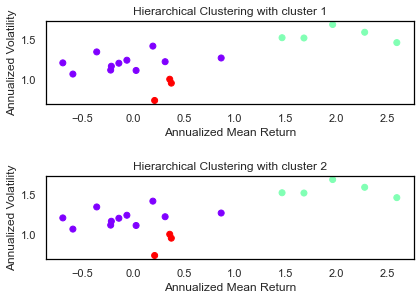

In [ ]:
plt.figure(figsize=(14,7))
fig,ax= plt.subplots(2,1)
fig.tight_layout(h_pad=4)
sns.set(rc={'axes.facecolor':'white','axes.edgecolor':'black'})
#plt.scatter(X.iloc[:,0],X.iloc[:,1], c =cluster_labels2,cmap='rainbow')
ax[0].scatter(data.iloc[:,0],data.iloc[:,1], c =cluster_labels3_1,cmap='rainbow')
ax[1].scatter(data.iloc[:,0],data.iloc[:,1], c =cluster_labels3_2,cmap='rainbow')
ax[0].set_title('Hierarchical Clustering with cluster 1')
ax[1].set_title('Hierarchical Clustering with cluster 2')
ax[0].set_xlabel('Annualized Mean Return')
ax[1].set_xlabel('Annualized Mean Return')
ax[0].set_ylabel('Annualized Volatility')
ax[1].set_ylabel('Annualized Volatility')
#ax[0].set_colorbar()

## Collectively plotting the results

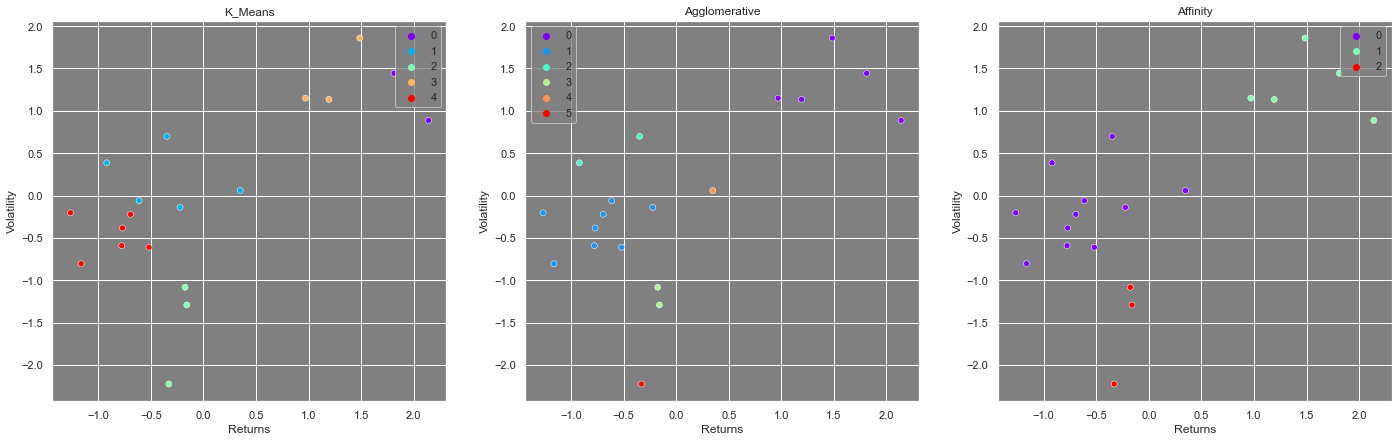

In [ ]:
#Normalised Graphs
plt.figure(figsize=(24,7))
sns.set(rc={'axes.facecolor':'grey'})
i=1
for c in [[cluster_labels1, 'K_Means'],[cluster_labels2,'Agglomerative'],[cluster_labels3_1,'Affinity']]:
    plt.subplot(1,3,i)
    i+=1
    sns.scatterplot(X.iloc[:,0],X.iloc[:,1], hue =c[0],palette='rainbow')
    plt.title(c[1])

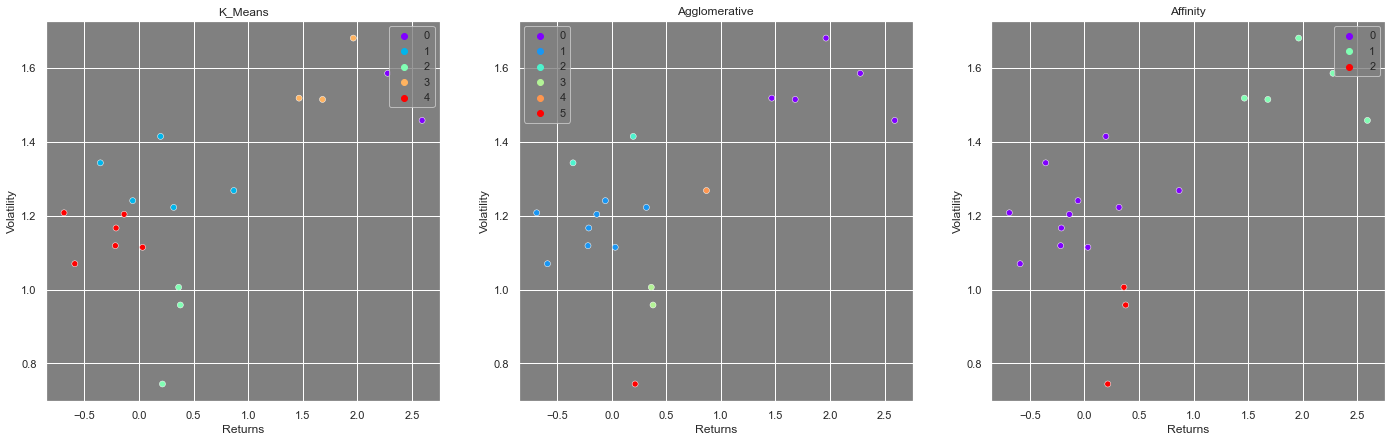

In [ ]:
#Denormalised Graphs
plt.figure(figsize=(24,7))
sns.set(rc={'axes.facecolor':'grey'})
i=1
for c in [[cluster_labels1, 'K_Means'],[cluster_labels2,'Agglomerative'],[cluster_labels3_1,'Affinity']]:
    plt.subplot(1,3,i)
    i+=1
    sns.scatterplot(data.iloc[:,0],data.iloc[:,1], hue =c[0],palette='rainbow')
    plt.title(c[1])

In [ ]:
#data
cluster_labels2

array([5, 1, 2, 0, 0, 0, 1, 2, 4, 0, 0, 1, 1, 1, 1, 1, 3, 1, 3],
      dtype=int64)

## Selecting best model

In [ ]:
print("KNN: {0}".format(metrics.silhouette_score(X, cluster_labels1,metric='euclidean',random_state=seed)))
print("Agglomerative: {0}".format(metrics.silhouette_score(X, cluster_labels2,metric='euclidean',random_state=seed)))
print("Affinity Propagation 1: {0}".format(metrics.silhouette_score(X, cluster_labels3_1,metric='euclidean',random_state=seed)))
print("Affinity Propagation 2: {0}".format(metrics.silhouette_score(X, cluster_labels3_2,metric='euclidean',random_state=seed)))

KNN: 0.31945362160347357
Agglomerative: 0.37855912592175744
Affinity Propagation 1: 0.5208157797324696
Affinity Propagation 2: 0.5208157797324696


In [ ]:
cluster_labels3_1

array([2, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 2],
      dtype=int64)

In [ ]:
#pwd

In [ ]:
clustered_series= pd.Series(index=X.index, data= cluster_labels3_1)
counts= clustered_series.value_counts()
#cluster_vis = list

In [ ]:
(counts[0])

11

In [ ]:
clustered_series[clustered_series==1].index


Index(['CRV', 'SOL', 'MANA', 'MATIC', 'ENJ'], dtype='object')

In [ ]:
len(np.unique(cluster_labels3_1))

3

In [ ]:
plt.figure(figsize=(14,7))
cluster_list=[]
da1_pct=da1.pct_change(periods=24*12)

for i in range(0,len(np.unique(cluster_labels3_1))):
    if(counts[i]>1):
        cluster_list.append(clustered_series[clustered_series==i].index)







<Figure size 1008x504 with 0 Axes>

<AxesSubplot:xlabel='Observation Time', ylabel='Price'>

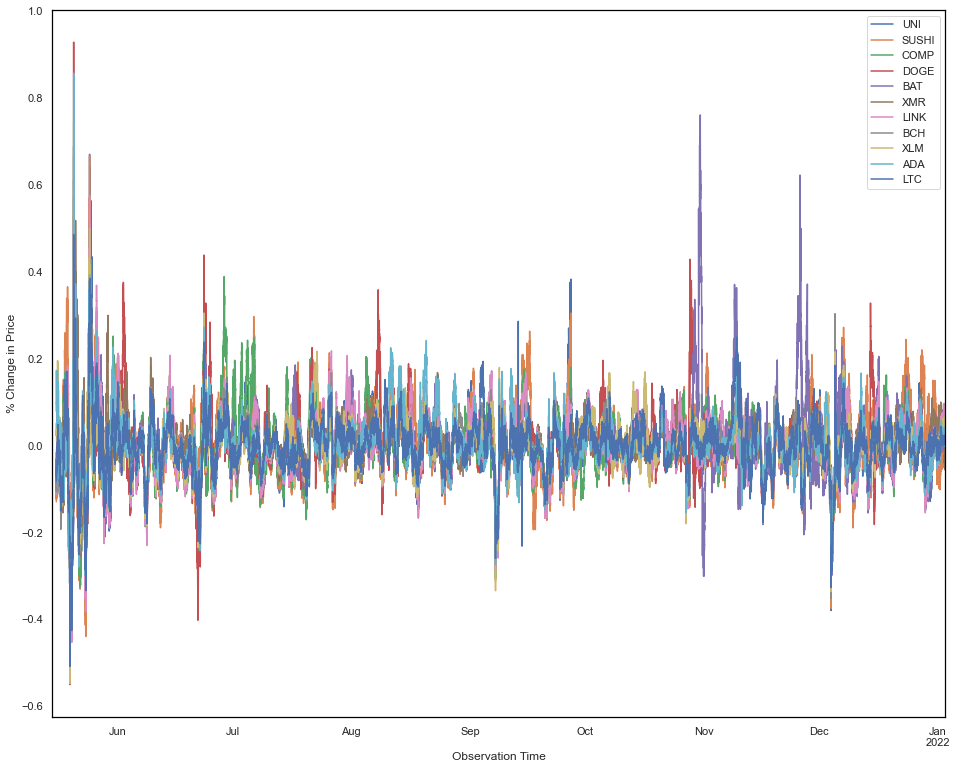

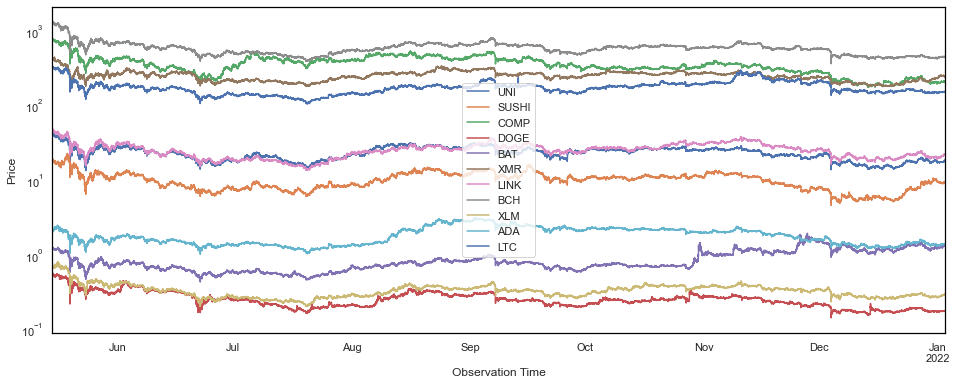

In [ ]:
sns.set(rc={'axes.facecolor':'white','axes.edgecolor':'black'})
da1_pct[cluster_list[0]].plot(figsize=(16,13),xlabel= 'Observation Time',ylabel= '% Change in Price')
da1[cluster_list[0]].plot(figsize=(16,6),logy=True,secondary_y='SOL',grid=True,xlabel='Observation Time',ylabel= 'Price')

<AxesSubplot:xlabel='Observation Time', ylabel='Log Price'>

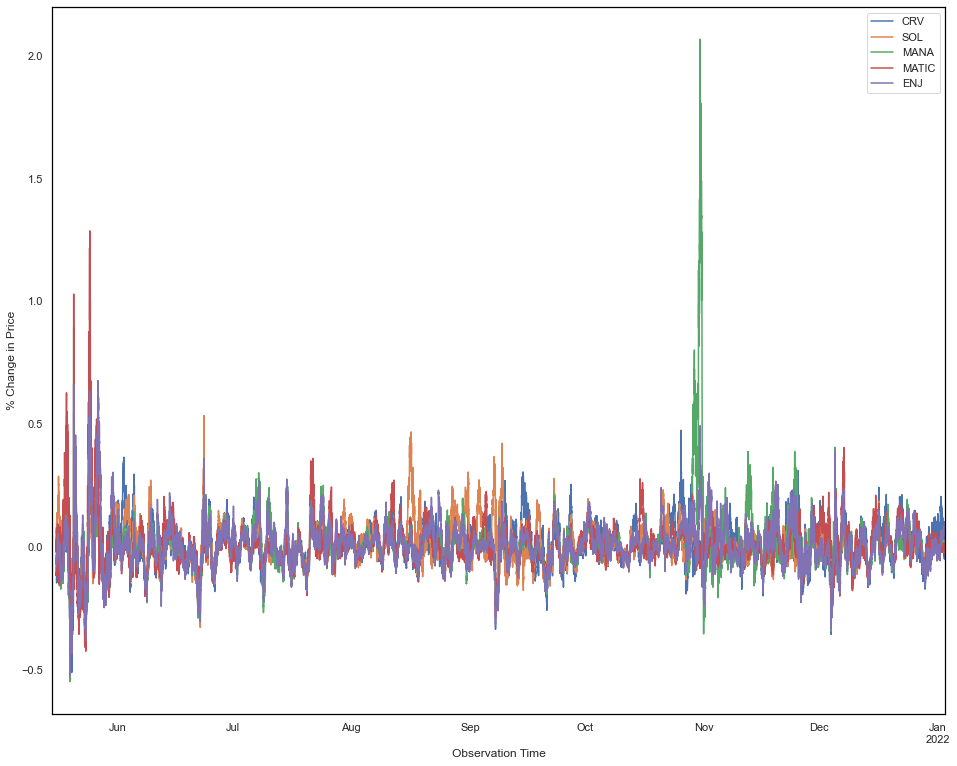

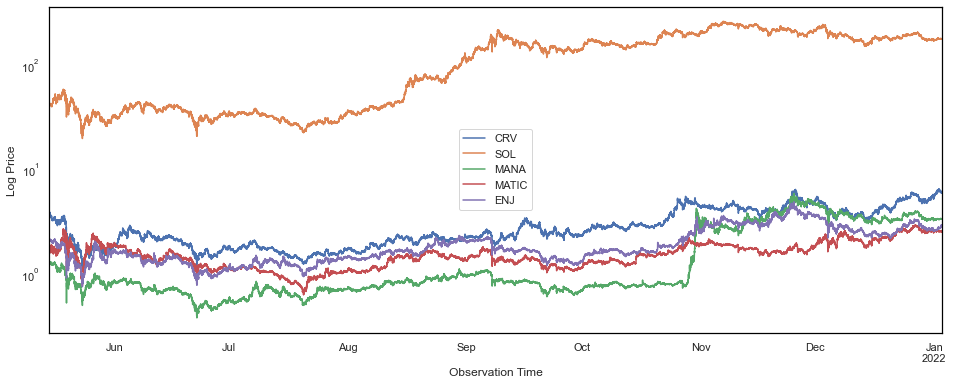

In [ ]:
da1_pct[cluster_list[1]].plot(figsize=(16,13),xlabel= 'Observation Time',ylabel= '% Change in Price')
da1[cluster_list[1]].plot(figsize=(16,6),logy=True,secondary_y=['COMP','BCH','LTC'],xlabel='Observation Time',ylabel= 'Log Price')
#da1[cluster_list[1]].plot(figsize=(16,6),subplots=[('COMP', 'BTC'), ('LTC', 'DOGE')] )

<AxesSubplot:xlabel='Observation Time', ylabel='Log Price'>

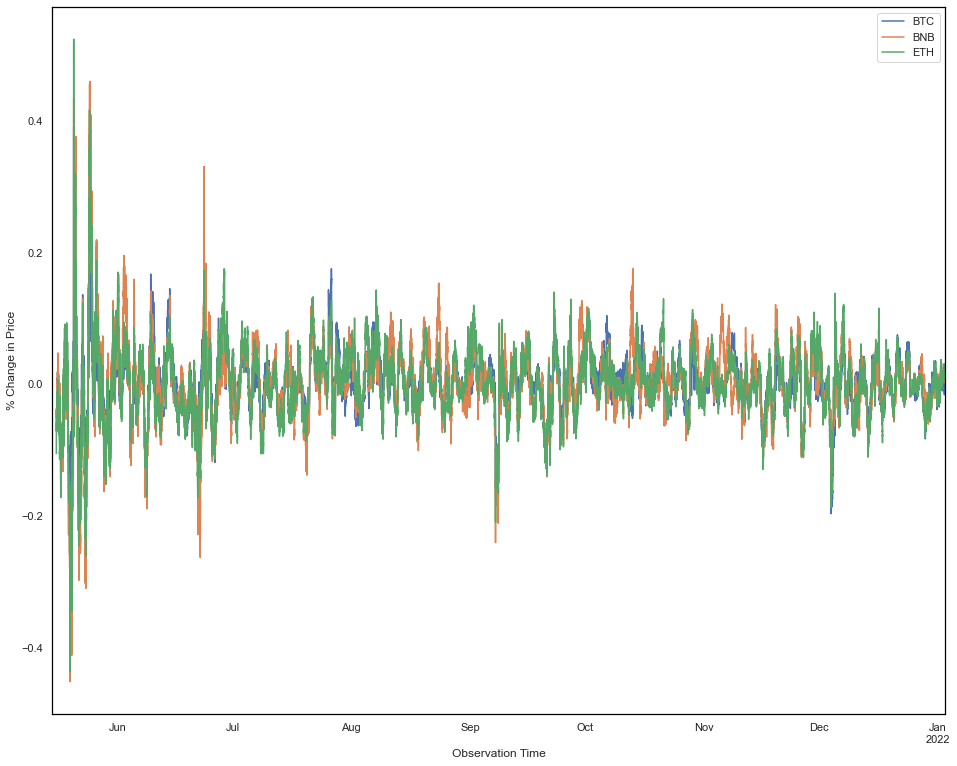

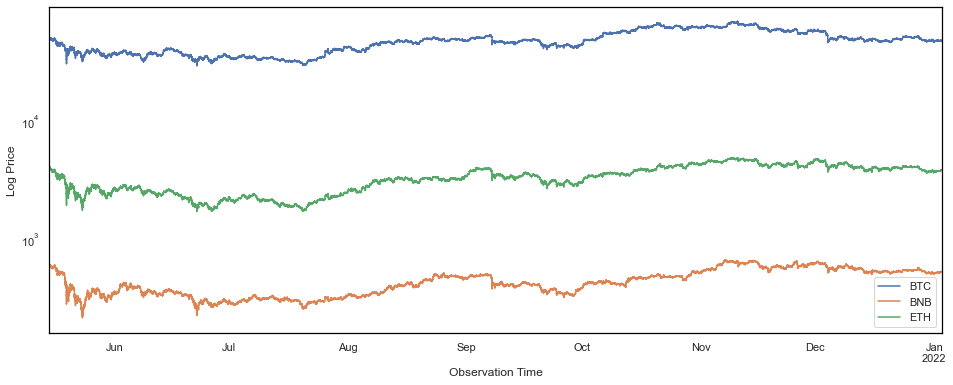

In [ ]:
da1_pct[cluster_list[2]].plot(figsize=(16,13),xlabel= 'Observation Time',ylabel= '% Change in Price')
da1[cluster_list[2]].plot(figsize=(16,6),grid=True,logy=True,xlabel='Observation Time',ylabel= 'Log Price')

In [ ]:
cluster_list[0]

Index(['UNI', 'SUSHI', 'COMP', 'DOGE', 'BAT', 'XMR', 'LINK', 'BCH', 'XLM',
       'ADA', 'LTC'],
      dtype='object')

## Statistical Tests:
ADF(Dicky Fuller) Test>>
Cointegration Test>>
2 step Engle-Granger Approach with Error correcting model.

In [ ]:
da1=da_1[st:en_mid]

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
#ADF test
def ADFtest(df,clust_list):
    clust_list1=[]

    for i in tqdm_notebook(range(0,len(np.unique(cluster_labels3_1))),desc='Cluster Checking'):
        temp=[]
        for stock in tqdm_notebook(list(clust_list[i])):
            result=adfuller(df[stock])
            #print('p-value: {0} for {1}'.format(result[1],stock))
            if(result[1]<=0.05):
                pass
                #print("Against Null hypo data is stationary")
            else:
                #print("For Null hypo data is not stationary")
                temp.append(stock)
                print(stock)
        clust_list1.append(temp)

    return clust_list1


In [ ]:
cluster_list1= ADFtest(da1,cluster_list)

Cluster Checking:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

BAT
ADA


  0%|          | 0/5 [00:00<?, ?it/s]

CRV
SOL
MANA
MATIC
ENJ


  0%|          | 0/3 [00:00<?, ?it/s]

BTC
BNB
ETH


In [ ]:
da1_diff=pd.DataFrame()
for i in coin:
    da1_diff[i]=da1[i]-da1[i].shift(1)
da1_diff.fillna(method='bfill',inplace=True)
da1.fillna(method='bfill',inplace=True)
da1_diff_1=da1_diff.shift(1)
da1_diff_1.fillna(method='bfill',inplace=True)

In [ ]:
def ADFtest_diff(df,clust_list):
    clust_list1=[]

    for i in tqdm_notebook(range(0,len(np.unique(cluster_labels3_1))),desc='Cluster Checking'):
        temp=[]
        for stock in tqdm_notebook(list(clust_list[i])):
            result=adfuller(df[stock])
            #print('p-value: {0} for {1}'.format(result[1],stock))
            if(result[1]<=0.05):
                temp.append(stock)
                print(stock)
                #print("Against Null hypo data is stationary")

        clust_list1.append(temp)

    return clust_list1

In [ ]:
cluster_list1_final= ADFtest_diff(da1_diff,cluster_list1)

Cluster Checking:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

BAT
ADA


  0%|          | 0/5 [00:00<?, ?it/s]

CRV
SOL
MANA
MATIC
ENJ


  0%|          | 0/3 [00:00<?, ?it/s]

BTC
BNB
ETH


In [ ]:
print(cluster_list)
print(cluster_list1)
print(cluster_list1_final)

[Index(['UNI', 'SUSHI', 'COMP', 'DOGE', 'BAT', 'XMR', 'LINK', 'BCH', 'XLM',
       'ADA', 'LTC'],
      dtype='object'), Index(['CRV', 'SOL', 'MANA', 'MATIC', 'ENJ'], dtype='object'), Index(['BTC', 'BNB', 'ETH'], dtype='object')]
[['BAT', 'ADA'], ['CRV', 'SOL', 'MANA', 'MATIC', 'ENJ'], ['BTC', 'BNB', 'ETH']]
[['BAT', 'ADA'], ['CRV', 'SOL', 'MANA', 'MATIC', 'ENJ'], ['BTC', 'BNB', 'ETH']]


In [ ]:
#Coint Test
def coint(df):
    pair=pd.DataFrame()
    for i in tqdm(df.columns):
        for j in tqdm_notebook(df.columns):
            if i!=j:
                Y = df[i]
                X = df[j]
                X= sm.add_constant(X)
                model = sm.OLS(Y,X)
                results = model.fit()
                resid_dumm= pd.DataFrame(results.resid)
                p_value=adfuller(resid_dumm)
                if p_value[1]<0.05:
                    pair[(i,j)]= pd.DataFrame(results.resid)
    return pair

In [ ]:
pair0=  coint(da1[cluster_list1_final[0]])

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|██████████████████████████████████████████                                          | 1/2 [00:11<00:11, 11.87s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:23<00:00, 11.87s/it]


In [ ]:
pair0

""


In [ ]:
pair1=  coint(da1[cluster_list1_final[1]])

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|████████████████▊                                                                   | 1/5 [00:47<03:08, 47.12s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|█████████████████████████████████▌                                                  | 2/5 [01:34<02:21, 47.06s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:21<01:34, 47.13s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:08<00:47, 47.16s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:55<00:00, 47.12s/it]


In [ ]:
pair1

,"(CRV, MANA)","(MANA, CRV)","(MANA, ENJ)","(MATIC, CRV)","(ENJ, CRV)","(ENJ, MANA)"
ts,,,,,,
2021-05-15 00:00:00,1.012747,-0.990381,-0.577990,-0.252216,-0.241880,0.343833
2021-05-15 00:05:00,1.049575,-1.023472,-0.584426,-0.214593,-0.257850,0.348017
2021-05-15 00:10:00,1.095480,-1.064856,-0.571757,-0.210870,-0.290887,0.340154
2021-05-15 00:15:00,1.067936,-1.041426,-0.565712,-0.160100,-0.280628,0.335858
2021-05-15 00:20:00,1.008443,-0.991885,-0.532510,-0.183857,-0.271895,0.313568
...,...,...,...,...,...,...
2022-01-02 23:40:00,1.741065,-1.061974,0.307978,0.103770,-0.794614,-0.038774
2022-01-02 23:45:00,1.758365,-1.079308,0.304065,0.108028,-0.802788,-0.036780
2022-01-02 23:50:00,1.764475,-1.085649,0.321998,0.099877,-0.817995,-0.048310


In [ ]:
pair2=  coint(da1[cluster_list1_final[2]])

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████                                                        | 1/3 [00:22<00:45, 22.76s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:46<00:23, 23.30s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:09<00:00, 23.10s/it]


In [ ]:
pair2

,"(BNB, ETH)","(ETH, BNB)"
ts,,
2021-05-15 00:00:00,65.521026,-399.878543
2021-05-15 00:05:00,67.624380,-415.161565
2021-05-15 00:10:00,67.516652,-415.390382
2021-05-15 00:15:00,67.328805,-416.090406
2021-05-15 00:20:00,66.985085,-417.744260
...,...,...
2022-01-02 23:40:00,25.992405,-136.207572
2022-01-02 23:45:00,26.222719,-137.769742
2022-01-02 23:50:00,25.996684,-136.729316


In [ ]:
cluster_list1_final[0]

['BAT', 'ADA']

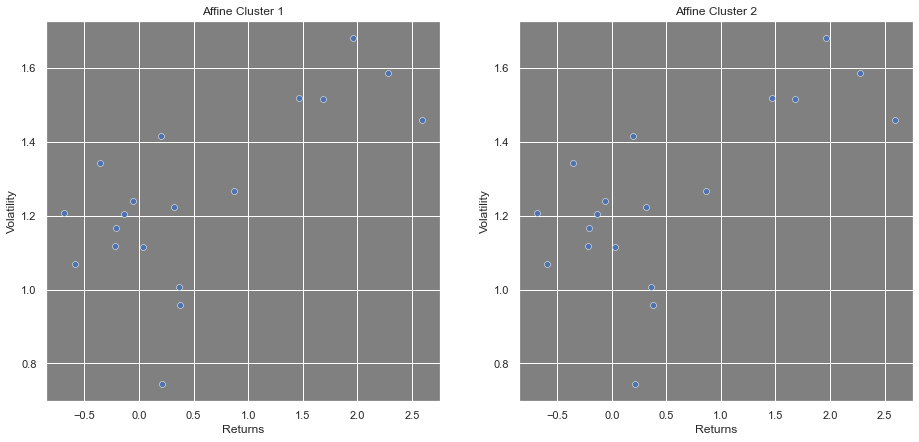

In [ ]:
plt.figure(figsize=(24,7))
sns.set(rc={'axes.facecolor':'grey'})
i=1
for c in [[cluster_list1_final[1],'Affine Cluster 1'],[cluster_list1_final[2],'Affine Cluster 2']]:
    plt.subplot(1,3,i)
    i+=1
    sns.scatterplot(data.iloc[:,0],data.iloc[:,1],palette='rainbow')
    plt.title(c[1])

In [ ]:
def ECM(df,df_diff,df_diff_1,pairi):

    sel_pair=[]
    error_coeff=[]

    for i in tqdm(pairi.columns):

        y=pd.DataFrame()
        y= pd.DataFrame(df_diff[i[0]]) ###(Dependent,independent)
        X=pd.DataFrame()
        #X[str(i[0])+"1"]=df_diff_1[i[0]] #Extended eqn of Graner Approach.
        X[i[1]]=df_diff[i[1]]
        #X[str(i[1])+"1"]=-df_diff_1[i[1]].shift(1)  #re
        #X[str(i[0])+"0"]=df_diff_1[i[0]].shift(1)  #re

        X['residual']= pairi[i].shift(1)
        #X['residual'].fillna(method='bfill',inplace=True)
        X=sm.add_constant(X)
        X.fillna(method='bfill', inplace=True)
        y.fillna(method='bfill', inplace=True)

        #store= df[i[1]].shift(1)
        #store.fillna(method='bfill',inplace=True)
        #X[str(i[1])+'res']=df[i[1]]-store


        model=sm.OLS(y,X)
        results=model.fit()
        print("Error Coefficient of {0} pair is {1}".format(i,results.params.loc['residual']))
        print(results.summary())
        error_coeff.append(results.params.loc['residual'])
        sel_pair.append(i)


    ecm =pd.DataFrame()
    ecm['pairs']= sel_pair
    ecm['error_coeff']= error_coeff
    return ecm

In [ ]:
sel_pair0= ECM(da1[cluster_list1_final[0]],da1_diff[cluster_list1_final[0]],da1_diff_1[cluster_list1_final[0]],pair0)

0it [00:00, ?it/s]


In [ ]:
sel_pair1= ECM(da1[cluster_list1_final[1]],da1_diff[cluster_list1_final[1]],da1_diff_1[cluster_list1_final[1]],pair1)

 17%|██████████████                                                                      | 1/6 [00:00<00:01,  4.38it/s]

Error Coefficient of ('CRV', 'MANA') pair is -0.000226230277100253
                            OLS Regression Results                            
Dep. Variable:                    CRV   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     3833.
Date:                Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:19:47   Log-Likelihood:             1.8210e+05
No. Observations:               67105   AIC:                        -3.642e+05
Df Residuals:                   67102   BIC:                        -3.642e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

 33%|████████████████████████████                                                        | 2/6 [00:00<00:00,  4.55it/s]

Error Coefficient of ('MANA', 'CRV') pair is -0.00022684826896249375
                            OLS Regression Results                            
Dep. Variable:                   MANA   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     3836.
Date:                Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:19:47   Log-Likelihood:             1.9771e+05
No. Observations:               67105   AIC:                        -3.954e+05
Df Residuals:                   67102   BIC:                        -3.954e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

 50%|██████████████████████████████████████████                                          | 3/6 [00:00<00:00,  4.73it/s]

Error Coefficient of ('MANA', 'ENJ') pair is -0.00035980884484714345
                            OLS Regression Results                            
Dep. Variable:                   MANA   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                 1.207e+04
Date:                Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:19:47   Log-Likelihood:             2.0438e+05
No. Observations:               67105   AIC:                        -4.088e+05
Df Residuals:                   67102   BIC:                        -4.087e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

 67%|████████████████████████████████████████████████████████                            | 4/6 [00:00<00:00,  4.61it/s]

Error Coefficient of ('MATIC', 'CRV') pair is -0.0005663202345785878
                            OLS Regression Results                            
Dep. Variable:                  MATIC   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                 1.000e+04
Date:                Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:19:47   Log-Likelihood:             2.2096e+05
No. Observations:               67105   AIC:                        -4.419e+05
Df Residuals:                   67102   BIC:                        -4.419e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:01<00:00,  3.29it/s]

Error Coefficient of ('ENJ', 'CRV') pair is -0.0003950453462130595
                            OLS Regression Results                            
Dep. Variable:                    ENJ   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     8908.
Date:                Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:19:48   Log-Likelihood:             2.1220e+05
No. Observations:               67105   AIC:                        -4.244e+05
Df Residuals:                   67102   BIC:                        -4.244e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.91it/s]

                            OLS Regression Results                            
Dep. Variable:                    ENJ   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                 1.207e+04
Date:                Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:19:48   Log-Likelihood:             2.1461e+05
No. Observations:               67105   AIC:                        -4.292e+05
Df Residuals:                   67102   BIC:                        -4.292e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.637e-06   3.81e-05     -0.069      0.9

In [ ]:
sel_pair2= ECM(da1[cluster_list1_final[2]],da1_diff[cluster_list1_final[2]],da1_diff_1[cluster_list1_final[2]],pair2)

 50%|██████████████████████████████████████████                                          | 1/2 [00:00<00:00,  4.65it/s]

Error Coefficient of ('BNB', 'ETH') pair is -0.0003110263379823349
                            OLS Regression Results                            
Dep. Variable:                    BNB   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                 7.946e+04
Date:                Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:19:49   Log-Likelihood:                -79818.
No. Observations:               67105   AIC:                         1.596e+05
Df Residuals:                   67102   BIC:                         1.597e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.78it/s]

                            OLS Regression Results                            
Dep. Variable:                    ETH   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                 7.944e+04
Date:                Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:19:49   Log-Likelihood:            -2.1113e+05
No. Observations:               67105   AIC:                         4.223e+05
Df Residuals:                   67102   BIC:                         4.223e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.022      0.096      0.9

In [ ]:
sel_pair0.sort_values(by='error_coeff')

,pairs,error_coeff


In [ ]:
sel_pair1.sort_values(by='error_coeff')

,pairs,error_coeff
5,"(ENJ, MANA)",-0.000616
3,"(MATIC, CRV)",-0.000566
4,"(ENJ, CRV)",-0.000395
2,"(MANA, ENJ)",-0.000360
1,"(MANA, CRV)",-0.000227
0,"(CRV, MANA)",-0.000226


In [ ]:
sel_pair2.sort_values(by='error_coeff')

,pairs,error_coeff
0,"(BNB, ETH)",-0.000311
1,"(ETH, BNB)",-0.000180


In [ ]:
class Run:
    def __init__(self, da1,coin, level=0):
        self.level = level
        self.coin= coin
        self.da1 = da1
        self.entry_time=[]                          #Trade entry time
        self.exit_time=[]                           #Trade exit time
        self.signal_entry=[]                        #Entry trade signal
        self.signal_exit=[]                         #Exit trade signal
        self.entry_spread=[]                        #Storing entering original spread.
        self.exit_spread=[]                         #Storing exiting original spread.
        self.p1=[]
        self.p1_exit=[]
        self.p2=[]
        self.p2_exit=[]
        self.p1_quant=[]
        self.p2_quant=[]
        self.p1_entry_dir=[]
        self.p2_entry_dir=[]
        self.hedge_ratio=[]
        self.pnl1=[]
        self.pnl2=[]
        self.pnl=[]
        self.total_pnl=[]



        self.capital=[]
        self.cap = 1e5

    def zscore(self, series):
        return (series - series.mean())/np.std(series)
        #return (series - da_1[datetime.datetime(2021, 5, 15 , 0, 0):en_mid].mean())/np.std(da_1[datetime.datetime(2021, 5, 15 , 0, 0):en_mid])

    def level_crosses(self, series, level):
        change = 0
        if series[1]>level and series[0]<level:
            change=1
        elif series[1]<level and series[0]>level:
            change=-1
        else:
            change=0
        return change

    def run(self):
        st = datetime.datetime(2021, 5, 15 , 0, 0)
        #st= datetime.datetime(2022, 1, 3, 0, 0)
        #en = datetime.datetime(2022, 4, 3, 0, 0)       #end date
        en= datetime.datetime(2022, 1, 4, 0, 0)
        en1=st+datetime.timedelta(days=2)               #rolling end date

        entry_level=0
        open_pos=False
        coin1_dir = None

        while(en1<en-datetime.timedelta(minutes=5)):
            #Data Loading and Regression in every 5 min
            data=self.da1[st:en1]
            r=sm.OLS(data[self.coin[0]],data[self.coin[1]]).fit() #(MANA,ADA)
            hedge=r.params
            data['spread']=data[self.coin[0]]-data[self.coin[1]]*hedge[0]
            data['n_spread']= self.zscore(data['spread'])

            upper_trading=self.level_crosses(data['n_spread'].tail(2), level=1)
            lower_trading=self.level_crosses(data['n_spread'].tail(2), level=-1)
            upper_stop=self.level_crosses(data['n_spread'].tail(2), level=2)
            lower_stop=self.level_crosses(data['n_spread'].tail(2), level=-2)
            mean=self.level_crosses(data['n_spread'].tail(2), level=0)


            #Trading signals
            if open_pos==True:

                if (upper_stop == 1 and f==1) or (lower_stop == -1 and f==-1):
                    open_pos=False
                    self.signal_exit.append('Stop Loss Hit')
                    #profits.append(-abs(data['spread'].tail(1)[0]-entry_level)*Qt)
                    #profits_per.append(-abs(data['spread'].tail(1)[0]-entry_level))
                    #cum_profits.append(np.sum(profits))
                    #cum_profits_per.append(np.sum(profits_per))
                    #self.cap=self.cap+profits[-1]
                    #self.capital.append(self.cap+cum_profits[-1])
                    self.exit_spread.append(data['spread'].tail(1)[0])
                    self.exit_time.append(data['n_spread'].tail(1).index[0])
                    self.p1_exit.append(data[self.coin[0]].tail(1)[0])
                    self.p2_exit.append(data[self.coin[1]].tail(1)[0])
                    print("Time : ", self.exit_time[-1])
                    print(f'====>Exiting {self.coin[1]} at price {self.p2_exit[-1]}, quantity : {Qt2}')
                    print(f'-----Exiting {self.coin[0]} at price {self.p1_exit[-1]}, quantity : {Qt1}')

                    if coin1_dir == 'sell':
                        self.pnl1.append((self.p1[-1]-self.p1_exit[-1])*Qt1)
                        self.pnl2.append((self.p2_exit[-1]-self.p2[-1])*Qt2)
                    else:
                        self.pnl1.append((self.p1_exit[-1]-self.p1[-1])*Qt1)
                        self.pnl2.append((self.p2[-1]-self.p2_exit[-1])*Qt2)

                    self.pnl.append(self.pnl1[-1] + self.pnl2[-1])
                    self.total_pnl.append(np.sum(self.pnl))

                    print(f'self.pnl1 : {self.pnl1[-1]} , self.pnl2 : {self.pnl2[-1]}, pnl : {self.pnl[-1]}, total_pnl : {self.total_pnl[-1]} ')

                elif mean!=0:
                    open_pos=False
                    self.signal_exit.append('Target Hit')
                    #profits.append(abs(data['spread'].tail(1)[0] - entry_level)*Qt)
                    #profits_per.append(abs(data['spread'].tail(1)[0] - entry_level))
                    #self.cap=self.cap+profits[-1]
                    #cum_profits.append(np.sum(profits))
                    #cum_profits_per.append(np.sum(profits_per))
                    #self.capital.append(self.cap+cum_profits[-1])

                    self.exit_spread.append(data['spread'].tail(1)[0])
                    self.exit_time.append(data['n_spread'].tail(1).index[0])
                    self.p1_exit.append(data[self.coin[0]].tail(1)[0])
                    self.p2_exit.append(data[self.coin[1]].tail(1)[0])
                    print("Time : ", self.exit_time[-1])
                    print(f'====>Exiting {self.coin[1]} at price {self.p2_exit[-1]}, quantity : {Qt2}')
                    print(f'-----Exiting {self.coin[0]} at price {self.p1_exit[-1]}, quantity : {Qt1}')

                    if coin1_dir == 'sell':
                        self.pnl1.append((self.p1[-1]-self.p1_exit[-1])*Qt1)
                        self.pnl2.append((self.p2_exit[-1]-self.p2[-1])*Qt2)
                    else:
                        self.pnl1.append((self.p1_exit[-1]-self.p1[-1])*Qt1)
                        self.pnl2.append((self.p2[-1]-self.p2_exit[-1])*Qt2)

                    self.pnl.append(self.pnl1[-1] + self.pnl2[-1])
                    self.total_pnl.append(np.sum(self.pnl))

                    print(f'self.pnl1 : {self.pnl1[-1]} , self.pnl2 : {self.pnl2[-1]}, pnl : {self.pnl[-1]}, total_pnl : {self.total_pnl[-1]} ')
                    #print(data['n_spread'].tail(2))

                    #print("MANA exit price is {0} and ADA is {1} with mean {2} ".format(self.p1_exit[-1],self.p2_exit[-1],mean))


            else:
                if(upper_trading==-1 or lower_trading==1):
                    open_pos=True
                    #self.p1.append(data[''])
                    self.p1.append(data[self.coin[0]].tail(1)[0])
                    self.p2.append(data[self.coin[1]].tail(1)[0])
                   # print("MANA entry price is {0} and ADA is {1}".format(self.p1[-1],self.p2[-1]))
                    entry_level= data['spread'].tail(1)[0]
                    self.entry_time.append(data['n_spread'].tail(1).index[0])
                    #Qt1= int(np.floor((self.cap/2)/data[coin[0]].tail(1)[0]))
                    Qt1=(self.cap/((hedge[0])*self.p2[-1]+self.p1[-1]))
                    self.p1_quant.append(Qt1)
                    Qt2=(Qt1*(hedge[0]))
                    self.p2_quant.append(Qt2)
                    #Qt2= int(np.floor((self.cap/2)/data[coin[1]].tail(1)[0]))
                    #quantity.append((Qt1,Qt2))
                    #print(data['n_spread'].tail(2))
                    self.hedge_ratio.append(hedge[0])

                    self.entry_spread.append(data['spread'].tail(1)[0])
                    if upper_trading == -1:
                        self.signal_entry.append('Short Activate')
                        self.p1_entry_dir.append('Sell')
                        self.p2_entry_dir.append('Buy')

                        print('Hedge Ratio : ', hedge[0])
                        print("Time : ", data['n_spread'].tail(1).index[0])
                        print(f'====>Bought {self.coin[1]} at price {self.p2[-1]}, quantity : {Qt2}')
                        print(f'-----Sold {self.coin[0]} at price {self.p1[-1]}, quantity : {Qt1}')
                        coin1_dir = 'sell'
                        f=1
                        #print("Hedge ratio is" hedge[0])

                    else:
                        self.signal_entry.append('Buy Activate')
                        self.p1_entry_dir.append('Buy')
                        self.p2_entry_dir.append('Sell')

                        print('Hedge Ratio : ', hedge[0])
                        print("Time : ", data['n_spread'].tail(1).index[0])
                        print(f'====>Sold {self.coin[1]} at price {self.p2[-1]}, quantity : {Qt2}')
                        print(f'-----Bought {self.coin[0]} at price {self.p1[-1]}, quantity : {Qt1}')
                        coin1_dir = 'buy'
                        f=-1
                        #print("Hedge ratio is ",hedge[0])

            #Time shift by 5 min

            st=st+datetime.timedelta(minutes=5)
            en1=en1+datetime.timedelta(minutes=5)
        if(open_pos==True):
            self.exit_time.append("NA")
            self.signal_exit.append("NA")
            self.p1_exit.append("NA")
            self.p2_exit.append("NA")
            self.exit_spread.append('NA')
            self.pnl1.append('NA')
            self.pnl2.append('NA')
            self.total_pnl.append(self.total_pnl[-1])
        return self.total_pnl, self.entry_time

In [ ]:
#Backtested Result (n day sample with regression in 5 min)
coin1=['ENJ', 'MANA']
#Storing different rolling sample day in 'coin1_train':
#-32150 1 day
#24922  2 day
#22417  3 day
#27207  4 day
#8563   5 day
#34277  6 day
#45623  7 day

trade = Run(da_1[st:en_mid],coin1)
pnl1_train, pnl1_train_time= trade.run()

coin1_train= [-32150,24922,22417,27207,8563,34277,45623]

Hedge Ratio :  1.645165878149485
Time :  2021-05-17 00:25:00
====>Bought MANA at price 1.165, quantity : 42790.284541302826
-----Sold ENJ at price 1.9281, quantity : 26009.70826688564
Time :  2021-05-17 00:35:00
====>Exiting MANA at price 1.1724, quantity : 42790.284541302826
-----Exiting ENJ at price 1.9764, quantity : 26009.70826688564
self.pnl1 : -1256.2689092905766 , self.pnl2 : 316.64810560564405, pnl : -939.6208036849325, total_pnl : -939.6208036849325 
Hedge Ratio :  1.647807561849714
Time :  2021-05-17 04:40:00
====>Bought MANA at price 1.067, quantity : 46590.21124677641
-----Sold ENJ at price 1.7786, quantity : 28274.06083418957
Time :  2021-05-17 08:55:00
====>Exiting MANA at price 1.1261, quantity : 46590.21124677641
-----Exiting ENJ at price 1.9024, quantity : 28274.06083418957
self.pnl1 : -3500.3287312726725 , self.pnl2 : 2753.481484684493, pnl : -746.8472465881796, total_pnl : -1686.468050273112 
Hedge Ratio :  1.650390121044933
Time :  2021-05-17 10:10:00
====>Bought MA

Time :  2021-05-22 07:45:00
====>Exiting MANA at price 0.7338, quantity : 67340.02913290863
-----Exiting ENJ at price 1.1468, quantity : 42895.07845136302
self.pnl1 : 1110.9825318903038 , self.pnl2 : -282.828122358215, pnl : 828.1544095320887, total_pnl : -6504.091116649112 
Hedge Ratio :  1.576928907181287
Time :  2021-05-22 16:00:00
====>Sold MANA at price 0.7658, quantity : 65614.81838761087
-----Bought ENJ at price 1.1957, quantity : 41609.243187059954
Time :  2021-05-22 17:00:00
====>Exiting MANA at price 0.7661, quantity : 65614.81838761087
-----Exiting ENJ at price 1.2103, quantity : 41609.243187059954
self.pnl1 : 607.4949505310731 , self.pnl2 : -19.68444551628109, pnl : 587.8105050147919, total_pnl : -5916.28061163432 
Hedge Ratio :  1.5775194424423924
Time :  2021-05-22 19:05:00
====>Sold MANA at price 0.7475, quantity : 67248.79692098158
-----Bought ENJ at price 1.1666, quantity : 42629.45679887388
Time :  2021-05-22 20:35:00
====>Exiting MANA at price 0.7526, quantity : 6724

Time :  2021-05-31 16:35:00
====>Exiting MANA at price 0.8246, quantity : 60985.08567321952
-----Exiting ENJ at price 1.5945, quantity : 33114.318332227966
self.pnl1 : -1119.263959629307 , self.pnl2 : 1969.81826724499, pnl : 850.554307615683, total_pnl : -13399.047270592022 
Hedge Ratio :  1.9603062341415303
Time :  2021-06-01 00:10:00
====>Sold MANA at price 0.8609, quantity : 58779.3100245822
-----Bought ENJ at price 1.6474, quantity : 29984.75901410537
Time :  2021-06-01 00:15:00
====>Exiting MANA at price 0.8529, quantity : 58779.3100245822
-----Exiting ENJ at price 1.6851, quantity : 29984.75901410537
self.pnl1 : 1130.4254148317743 , self.pnl2 : 470.234480196658, pnl : 1600.6598950284324, total_pnl : -11798.38737556359 
Hedge Ratio :  1.9765795915774895
Time :  2021-06-01 09:05:00
====>Sold MANA at price 0.8253, quantity : 61257.54710344509
-----Bought ENJ at price 1.5954, quantity : 30991.692600931907
Time :  2021-06-01 22:35:00
====>Exiting MANA at price 0.825, quantity : 61257.

Hedge Ratio :  1.8349914732391484
Time :  2021-06-05 18:25:00
====>Sold MANA at price 0.8193, quantity : 61587.05251559666
-----Bought ENJ at price 1.4761, quantity : 33562.58239548246
Time :  2021-06-06 05:55:00
====>Exiting MANA at price 0.822, quantity : 61587.05251559666
-----Exiting ENJ at price 1.4932, quantity : 33562.58239548246
self.pnl1 : 573.9201589627539 , self.pnl2 : -166.28504179210634, pnl : 407.6351171706476, total_pnl : -15985.293618705753 
Hedge Ratio :  1.8150598496047534
Time :  2021-06-06 07:10:00
====>Sold MANA at price 0.8179, quantity : 61518.330069822674
-----Bought ENJ at price 1.4659, quantity : 33893.27910218436
Time :  2021-06-06 12:10:00
====>Exiting MANA at price 0.8203, quantity : 61518.330069822674
-----Exiting ENJ at price 1.4906, quantity : 33893.27910218436
self.pnl1 : 837.1639938239517 , self.pnl2 : -147.64399216757866, pnl : 689.5200016563731, total_pnl : -15295.77361704938 
Hedge Ratio :  1.809931669371708
Time :  2021-06-06 13:05:00
====>Bought M

Hedge Ratio :  1.8262667385799654
Time :  2021-06-09 03:05:00
====>Bought MANA at price 0.6757, quantity : 73538.71850684442
-----Sold ENJ at price 1.2494, quantity : 40267.23859846744
Time :  2021-06-09 05:35:00
====>Exiting MANA at price 0.6885, quantity : 73538.71850684442
-----Exiting ENJ at price 1.2944, quantity : 40267.23859846744
self.pnl1 : -1812.025736931032 , self.pnl2 : 941.295596887611, pnl : -870.730140043421, total_pnl : -19158.572921514806 
Hedge Ratio :  1.8388005353376764
Time :  2021-06-09 12:55:00
====>Bought MANA at price 0.7018, quantity : 70680.4115545629
-----Sold ENJ at price 1.3111, quantity : 38438.32443826387
Time :  2021-06-09 20:20:00
====>Exiting MANA at price 0.7136, quantity : 70680.4115545629
-----Exiting ENJ at price 1.3142, quantity : 38438.32443826387
self.pnl1 : -119.15880575862195 , self.pnl2 : 834.0288563438446, pnl : 714.8700505852227, total_pnl : -18443.702870929585 
Hedge Ratio :  1.853276859189546
Time :  2021-06-10 02:10:00
====>Sold MANA at

Hedge Ratio :  1.8699331537987496
Time :  2021-06-14 03:10:00
====>Bought MANA at price 0.6831, quantity : 72886.21071691356
-----Sold ENJ at price 1.2882, quantity : 38977.976602450195
Time :  2021-06-14 05:35:00
====>Exiting MANA at price 0.6902, quantity : 72886.21071691356
-----Exiting ENJ at price 1.3181, quantity : 38977.976602450195
self.pnl1 : -1165.4415004132622 , self.pnl2 : 517.4920960900859, pnl : -647.9494043231764, total_pnl : -12270.252066131086 
Hedge Ratio :  1.8738175649074833
Time :  2021-06-14 07:10:00
====>Bought MANA at price 0.6981, quantity : 71342.43189825483
-----Sold ENJ at price 1.3184, quantity : 38073.307260185305
Time :  2021-06-14 07:35:00
====>Exiting MANA at price 0.6961, quantity : 71342.43189825483
-----Exiting ENJ at price 1.3363, quantity : 38073.307260185305
self.pnl1 : -681.512199957318 , self.pnl2 : -142.68486379650977, pnl : -824.1970637538277, total_pnl : -13094.449129884913 
Hedge Ratio :  1.8763752833759184
Time :  2021-06-14 08:55:00
====>B

Time :  2021-06-20 04:10:00
====>Exiting MANA at price 0.6308, quantity : 79933.45433112115
-----Exiting ENJ at price 1.2495, quantity : 40328.54345841552
self.pnl1 : 580.7310258011822 , self.pnl2 : -231.8070175602524, pnl : 348.9240082409298, total_pnl : -14688.372461064573 
Hedge Ratio :  1.976679426537318
Time :  2021-06-20 08:50:00
====>Sold MANA at price 0.6238, quantity : 80432.84222703554
-----Bought ENJ at price 1.2245, quantity : 40690.88854126192
Time :  2021-06-20 12:30:00
====>Exiting MANA at price 0.5828, quantity : 80432.84222703554
-----Exiting ENJ at price 1.1513, quantity : 40690.88854126192
self.pnl1 : -2978.5730412203698 , self.pnl2 : 3297.74653130846, pnl : 319.17349008809015, total_pnl : -14369.198970976482 
Hedge Ratio :  1.9777435496124935
Time :  2021-06-20 19:45:00
====>Bought MANA at price 0.627, quantity : 79387.75136069286
-----Sold ENJ at price 1.2512, quantity : 40140.56897126404
Time :  2021-06-20 23:15:00
====>Exiting MANA at price 0.6233, quantity : 793

Hedge Ratio :  2.0201804069758627
Time :  2021-06-27 00:05:00
====>Bought MANA at price 0.4662, quantity : 106813.92422805843
-----Sold ENJ at price 0.9495, quantity : 52873.45816206337
Time :  2021-06-27 03:40:00
====>Exiting MANA at price 0.4747, quantity : 106813.92422805843
-----Exiting ENJ at price 0.978, quantity : 52873.45816206337
self.pnl1 : -1506.8935576188044 , self.pnl2 : 907.9183559384975, pnl : -598.9752016803069, total_pnl : -15371.059506350795 
Hedge Ratio :  2.0232781811278175
Time :  2021-06-27 05:20:00
====>Bought MANA at price 0.475, quantity : 104846.25983994151
-----Sold ENJ at price 0.9687, quantity : 51819.992336149255
Time :  2021-06-27 06:45:00
====>Exiting MANA at price 0.4701, quantity : 104846.25983994151
-----Exiting ENJ at price 0.951, quantity : 51819.992336149255
self.pnl1 : 917.2138643498444 , self.pnl2 : -513.7466732157092, pnl : 403.4671911341352, total_pnl : -14967.59231521666 
Hedge Ratio :  2.0235139882799005
Time :  2021-06-27 10:10:00
====>Bough

Time :  2021-06-30 01:10:00
====>Exiting MANA at price 0.548, quantity : 89651.93178712578
-----Exiting ENJ at price 1.0945, quantity : 44892.34251362177
self.pnl1 : 884.3791475183511 , self.pnl2 : -851.6933519776907, pnl : 32.68579554066048, total_pnl : -18497.509249826202 
Hedge Ratio :  1.9980480855866156
Time :  2021-06-30 03:50:00
====>Bought MANA at price 0.5385, quantity : 92363.30091496967
-----Sold ENJ at price 1.0873, quantity : 46226.76580271206
Time :  2021-06-30 04:20:00
====>Exiting MANA at price 0.5364, quantity : 92363.30091496967
-----Exiting ENJ at price 1.0971, quantity : 46226.76580271206
self.pnl1 : -453.02230486657965 , self.pnl2 : -193.96293192143546, pnl : -646.9852367880151, total_pnl : -19144.494486614218 
Hedge Ratio :  1.9988285370507748
Time :  2021-06-30 05:55:00
====>Bought MANA at price 0.5247, quantity : 94907.29104660274
-----Sold ENJ at price 1.0573, quantity : 47481.4569070723
Time :  2021-06-30 09:45:00
====>Exiting MANA at price 0.5251, quantity : 

Hedge Ratio :  2.059473706228446
Time :  2021-07-03 23:55:00
====>Sold MANA at price 0.5616, quantity : 89286.1059241518
-----Bought ENJ at price 1.15, quantity : 43353.84601130119
Time :  2021-07-04 00:35:00
====>Exiting MANA at price 0.5556, quantity : 89286.1059241518
-----Exiting ENJ at price 1.1419, quantity : 43353.84601130119
self.pnl1 : -351.1661526915395 , self.pnl2 : 535.7166355449112, pnl : 184.55048285337176, total_pnl : -17497.55034369576 
Hedge Ratio :  2.0592982828891464
Time :  2021-07-04 01:45:00
====>Bought MANA at price 0.5444, quantity : 91614.68044693278
-----Sold ENJ at price 1.1267, quantity : 44488.30031480411
Time :  2021-07-04 04:25:00
====>Exiting MANA at price 0.5596, quantity : 91614.68044693278
-----Exiting ENJ at price 1.1519, quantity : 44488.30031480411
self.pnl1 : -1121.1051679330587 , self.pnl2 : 1392.5431427933775, pnl : 271.4379748603187, total_pnl : -17226.112368835442 
Hedge Ratio :  2.062483484915749
Time :  2021-07-04 07:55:00
====>Bought MANA a

Hedge Ratio :  1.8457530949022645
Time :  2021-07-10 08:20:00
====>Bought MANA at price 0.7238, quantity : 68294.04235596335
-----Sold ENJ at price 1.3667, quantity : 37000.6381376701
Time :  2021-07-10 09:05:00
====>Exiting MANA at price 0.73, quantity : 68294.04235596335
-----Exiting ENJ at price 1.3486, quantity : 37000.6381376701
self.pnl1 : 669.7115502918291 , self.pnl2 : 423.4230626069716, pnl : 1093.1346128988007, total_pnl : -18005.924012696563 
Hedge Ratio :  1.8495624872455951
Time :  2021-07-10 10:00:00
====>Sold MANA at price 0.7295, quantity : 69340.67301260453
-----Bought ENJ at price 1.3181, quantity : 37490.31108209165
Time :  2021-07-10 12:55:00
====>Exiting MANA at price 0.7565, quantity : 69340.67301260453
-----Exiting ENJ at price 1.3453, quantity : 37490.31108209165
self.pnl1 : 1019.7364614328887 , self.pnl2 : -1872.1981713403163, pnl : -852.4617099074276, total_pnl : -18858.38572260399 
Hedge Ratio :  1.8058345236456335
Time :  2021-07-11 03:00:00
====>Sold MANA a

Hedge Ratio :  1.904556749722856
Time :  2021-07-15 17:50:00
====>Sold MANA at price 0.642, quantity : 78683.6082572753
-----Bought ENJ at price 1.1978, quantity : 41313.34404644285
Time :  2021-07-15 20:10:00
====>Exiting MANA at price 0.661, quantity : 78683.6082572753
-----Exiting ENJ at price 1.2641, quantity : 41313.34404644285
self.pnl1 : 2739.074710279162 , self.pnl2 : -1494.9885568882319, pnl : 1244.0861533909301, total_pnl : -14836.617949735062 
Hedge Ratio :  1.9097656722136724
Time :  2021-07-15 23:00:00
====>Sold MANA at price 0.6727, quantity : 74907.47777427142
-----Bought ENJ at price 1.2648, quantity : 39223.386860568964
Time :  2021-07-16 01:00:00
====>Exiting MANA at price 0.6516, quantity : 74907.47777427142
-----Exiting ENJ at price 1.2455, quantity : 39223.386860568964
self.pnl1 : -757.0113664089761 , self.pnl2 : 1580.5477810371276, pnl : 823.5364146281515, total_pnl : -14013.08153510691 
Hedge Ratio :  1.9127020535727246
Time :  2021-07-16 10:45:00
====>Bought MAN

Time :  2021-07-21 03:15:00
====>Exiting MANA at price 0.5348, quantity : 93542.6492277588
-----Exiting ENJ at price 1.0218, quantity : 48822.37352706485
self.pnl1 : -170.87830734472982 , self.pnl2 : -84.18838430498403, pnl : -255.06669164971385, total_pnl : -11009.774205687412 
Hedge Ratio :  1.9157646015928291
Time :  2021-07-21 03:30:00
====>Sold MANA at price 0.5382, quantity : 92626.67292544055
-----Bought ENJ at price 1.0372, quantity : 48349.71522515225
Time :  2021-07-21 12:40:00
====>Exiting MANA at price 0.5655, quantity : 92626.67292544055
-----Exiting ENJ at price 1.0864, quantity : 48349.71522515225
self.pnl1 : 2378.805989077497 , self.pnl2 : -2528.708170864526, pnl : -149.9021817870289, total_pnl : -11159.676387474443 
Hedge Ratio :  1.9234464224568761
Time :  2021-07-21 16:25:00
====>Sold MANA at price 0.5832, quantity : 86162.25125836256
-----Bought ENJ at price 1.1106, quantity : 44795.76361077161
Time :  2021-07-21 17:00:00
====>Exiting MANA at price 0.5716, quantity 

Hedge Ratio :  1.8531852957321353
Time :  2021-07-24 14:25:00
====>Sold MANA at price 0.7404, quantity : 68051.79161837536
-----Bought ENJ at price 1.3511, quantity : 36721.5257832543
Time :  2021-07-24 15:45:00
====>Exiting MANA at price 0.7384, quantity : 68051.79161837536
-----Exiting ENJ at price 1.3147, quantity : 36721.5257832543
self.pnl1 : -1336.663538510456 , self.pnl2 : 136.10358323675084, pnl : -1200.559955273705, total_pnl : -10498.507775297052 
Hedge Ratio :  1.8479766350013693
Time :  2021-07-24 16:45:00
====>Sold MANA at price 0.7363, quantity : 68452.06722295926
-----Bought ENJ at price 1.339, quantity : 37041.63024924205
Time :  2021-07-24 17:40:00
====>Exiting MANA at price 0.7188, quantity : 68452.06722295926
-----Exiting ENJ at price 1.3314, quantity : 37041.63024924205
self.pnl1 : -281.51638989424146 , self.pnl2 : 1197.9111764017844, pnl : 916.3947865075429, total_pnl : -9582.112988789508 
Hedge Ratio :  1.8441807692189898
Time :  2021-07-24 19:20:00
====>Sold MANA

Hedge Ratio :  1.962562688494491
Time :  2021-07-29 14:45:00
====>Bought MANA at price 0.6975, quantity : 70914.96189463325
-----Sold ENJ at price 1.3986, quantity : 36133.85819998092
Time :  2021-07-29 22:20:00
====>Exiting MANA at price 0.705, quantity : 70914.96189463325
-----Exiting ENJ at price 1.3867, quantity : 36133.85819998092
self.pnl1 : 429.9929125797737 , self.pnl2 : 531.8622142097458, pnl : 961.8551267895195, total_pnl : -2800.450677429033 
Hedge Ratio :  1.9969871894731315
Time :  2021-07-30 23:00:00
====>Bought MANA at price 0.7104, quantity : 70004.39589383756
-----Sold ENJ at price 1.434, quantity : 35055.00499094686
Time :  2021-07-31 01:15:00
====>Exiting MANA at price 0.7105, quantity : 70004.39589383756
-----Exiting ENJ at price 1.42, quantity : 35055.00499094686
self.pnl1 : 490.77006987325643 , self.pnl2 : 7.000439589382985, pnl : 497.77050946263944, total_pnl : -2302.680167966393 
Hedge Ratio :  2.001322362747731
Time :  2021-07-31 05:00:00
====>Bought MANA at pr

Time :  2021-08-03 07:20:00
====>Exiting MANA at price 0.6774, quantity : 72178.03300523828
-----Exiting ENJ at price 1.3777, quantity : 35967.99899317037
self.pnl1 : 579.084783790043 , self.pnl2 : -974.4034455707136, pnl : -395.3186617806706, total_pnl : -155.0978738356207 
Hedge Ratio :  2.012063216535146
Time :  2021-08-03 09:15:00
====>Bought MANA at price 0.6751, quantity : 73884.79721452334
-----Sold ENJ at price 1.3649, quantity : 36720.9124481466
Time :  2021-08-03 10:20:00
====>Exiting MANA at price 0.684, quantity : 73884.79721452334
-----Exiting ENJ at price 1.374, quantity : 36720.9124481466
self.pnl1 : -334.16030327813803 , self.pnl2 : 657.5746952092591, pnl : 323.41439193112103, total_pnl : 168.31651809550021 
Hedge Ratio :  2.0122736923431144
Time :  2021-08-03 10:30:00
====>Sold MANA at price 0.6862, quantity : 73016.34591612167
-----Bought ENJ at price 1.3751, quantity : 36285.494460299094
Time :  2021-08-03 12:45:00
====>Exiting MANA at price 0.6871, quantity : 73016.

Time :  2021-08-07 20:05:00
====>Exiting MANA at price 0.7568, quantity : 66183.13173541022
-----Exiting ENJ at price 1.4679, quantity : 34110.0015600758
self.pnl1 : -64.80900296414445 , self.pnl2 : 92.65638442957881, pnl : 27.847381465434353, total_pnl : -447.99962089081237 
Hedge Ratio :  1.942268530629502
Time :  2021-08-07 21:30:00
====>Bought MANA at price 0.759, quantity : 65655.29088360669
-----Sold ENJ at price 1.4841, quantity : 33803.40557869585
Time :  2021-08-07 23:05:00
====>Exiting MANA at price 0.7687, quantity : 65655.29088360669
-----Exiting ENJ at price 1.4932, quantity : 33803.40557869585
self.pnl1 : -307.6109907661359 , self.pnl2 : 636.8563215709877, pnl : 329.2453308048518, total_pnl : -118.75429008595165 
Hedge Ratio :  1.9450920445844846
Time :  2021-08-08 01:50:00
====>Bought MANA at price 0.7496, quantity : 66463.85773616741
-----Sold ENJ at price 1.4685, quantity : 34170.03216953961
Time :  2021-08-08 02:50:00
====>Exiting MANA at price 0.757, quantity : 66463

Hedge Ratio :  1.9754028581456335
Time :  2021-08-14 07:45:00
====>Bought MANA at price 0.846, quantity : 58916.40871649805
-----Sold ENJ at price 1.6817, quantity : 29825.009351158147
Time :  2021-08-14 09:20:00
====>Exiting MANA at price 0.849, quantity : 58916.40871649805
-----Exiting ENJ at price 1.7139, quantity : 29825.009351158147
self.pnl1 : -960.3653011072926 , self.pnl2 : 176.74922614949432, pnl : -783.6160749577982, total_pnl : -1609.274644377936 
Hedge Ratio :  1.9793749003594745
Time :  2021-08-14 11:20:00
====>Bought MANA at price 0.8157, quantity : 61062.11409195184
-----Sold ENJ at price 1.627, quantity : 30849.190863672335
Time :  2021-08-14 14:50:00
====>Exiting MANA at price 0.8284, quantity : 61062.11409195184
-----Exiting ENJ at price 1.6768, quantity : 30849.190863672335
self.pnl1 : -1536.2897050108843 , self.pnl2 : 775.488848967791, pnl : -760.8008560430933, total_pnl : -2370.0755004210296 
Hedge Ratio :  1.9923471761062868
Time :  2021-08-14 20:10:00
====>Bought

Hedge Ratio :  1.9307754863216604
Time :  2021-08-19 20:25:00
====>Bought MANA at price 0.8048, quantity : 61987.37818666578
-----Sold ENJ at price 1.5609, quantity : 32104.912573112553
Time :  2021-08-19 22:25:00
====>Exiting MANA at price 0.81, quantity : 61987.37818666578
-----Exiting ENJ at price 1.5596, quantity : 32104.912573112553
self.pnl1 : 41.73638634504172 , self.pnl2 : 322.33436657066784, pnl : 364.0707529157096, total_pnl : 1343.7834996324746 
Hedge Ratio :  1.9317948716526185
Time :  2021-08-19 23:05:00
====>Bought MANA at price 0.8069, quantity : 61841.870220641285
-----Sold ENJ at price 1.565, quantity : 32012.648510520474
Time :  2021-08-19 23:55:00
====>Exiting MANA at price 0.8198, quantity : 61841.870220641285
-----Exiting ENJ at price 1.5822, quantity : 32012.648510520474
self.pnl1 : -550.6175543809554 , self.pnl2 : 797.7601258462739, pnl : 247.1425714653185, total_pnl : 1590.9260710977906 
Hedge Ratio :  1.9362678238708644
Time :  2021-08-20 05:45:00
====>Bought M

Hedge Ratio :  2.153793319750674
Time :  2021-08-26 12:05:00
====>Sold MANA at price 0.8845, quantity : 57250.824959362326
-----Bought ENJ at price 1.857, quantity : 26581.392204331733
Time :  2021-08-27 02:45:00
====>Exiting MANA at price 0.8831, quantity : 57250.824959362326
-----Exiting ENJ at price 1.881, quantity : 26581.392204331733
self.pnl1 : 637.9534129039622 , self.pnl2 : 80.15115494310479, pnl : 718.104567847067, total_pnl : -2625.1558381803898 
Hedge Ratio :  2.1211561864650776
Time :  2021-08-27 08:05:00
====>Bought MANA at price 0.8926, quantity : 55377.694008640145
-----Sold ENJ at price 1.937, quantity : 26107.315605517706
Time :  2021-08-28 04:05:00
====>Exiting MANA at price 0.9375, quantity : 55377.694008640145
-----Exiting ENJ at price 1.987, quantity : 26107.315605517706
self.pnl1 : -1305.3657802758864 , self.pnl2 : 2486.4584609879453, pnl : 1181.0926807120588, total_pnl : -1444.063157468332 
Hedge Ratio :  2.1439464939120634
Time :  2021-08-28 18:40:00
====>Bought

Hedge Ratio :  2.174560526442734
Time :  2021-09-01 01:30:00
====>Sold MANA at price 0.9233, quantity : 54695.30626748537
-----Bought ENJ at price 1.968, quantity : 25152.34945286116
Time :  2021-09-01 03:25:00
====>Exiting MANA at price 0.9592, quantity : 54695.30626748537
-----Exiting ENJ at price 2.0, quantity : 25152.34945286116
self.pnl1 : 804.8751824915578 , self.pnl2 : -1963.5614950027273, pnl : -1158.6863125111695, total_pnl : -3766.527799378444 
Hedge Ratio :  2.1732692763611943
Time :  2021-09-01 05:35:00
====>Sold MANA at price 0.9609, quantity : 52541.4547698132
-----Bought ENJ at price 2.048, quantity : 24176.228570159423
Time :  2021-09-02 07:50:00
====>Exiting MANA at price 0.9721, quantity : 52541.4547698132
-----Exiting ENJ at price 2.077, quantity : 24176.228570159423
self.pnl1 : 701.1106285346212 , self.pnl2 : -588.4642934219072, pnl : 112.64633511271404, total_pnl : -3653.881464265727 
Hedge Ratio :  2.1314256518988492
Time :  2021-09-02 14:20:00
====>Bought MANA at

Hedge Ratio :  2.0834904939336534
Time :  2021-09-08 03:55:00
====>Sold MANA at price 0.8373, quantity : 60086.12931261287
-----Bought ENJ at price 1.723, quantity : 28839.16652730658
Time :  2021-09-08 07:20:00
====>Exiting MANA at price 0.788, quantity : 60086.12931261287
-----Exiting ENJ at price 1.603, quantity : 28839.16652730658
self.pnl1 : -3460.699983276793 , self.pnl2 : 2962.2461751118153, pnl : -498.45380816497754, total_pnl : -2543.0397222348693 
Hedge Ratio :  2.059472948278489
Time :  2021-09-08 19:45:00
====>Sold MANA at price 0.8739, quantity : 57886.5686830683
-----Bought ENJ at price 1.758, quantity : 28107.467365111843
Time :  2021-09-08 20:40:00
====>Exiting MANA at price 0.8704, quantity : 57886.5686830683
-----Exiting ENJ at price 1.701, quantity : 28107.467365111843
self.pnl1 : -1602.1256398113733 , self.pnl2 : 202.60299039074243, pnl : -1399.5226494206308, total_pnl : -3942.5623716554983 
Hedge Ratio :  2.0532393436596403
Time :  2021-09-08 22:10:00
====>Sold MAN

Hedge Ratio :  2.0221052342687393
Time :  2021-09-13 15:05:00
====>Sold MANA at price 0.7838, quantity : 64052.980061878894
-----Bought ENJ at price 1.572, quantity : 31676.38309637361
Time :  2021-09-13 17:00:00
====>Exiting MANA at price 0.806, quantity : 64052.980061878894
-----Exiting ENJ at price 1.599, quantity : 31676.38309637361
self.pnl1 : 855.2623436020847 , self.pnl2 : -1421.9761573737112, pnl : -566.7138137716265, total_pnl : -1790.9716821499824 
Hedge Ratio :  2.017366532018699
Time :  2021-09-13 19:15:00
====>Sold MANA at price 0.8029, quantity : 62558.97489576578
-----Bought ENJ at price 1.605, quantity : 31010.217480492
Time :  2021-09-13 20:00:00
====>Exiting MANA at price 0.8227, quantity : 62558.97489576578
-----Exiting ENJ at price 1.619, quantity : 31010.217480492
self.pnl1 : 434.1430447268884 , self.pnl2 : -1238.667702936165, pnl : -804.5246582092766, total_pnl : -2595.496340359259 
Hedge Ratio :  2.01036475412346
Time :  2021-09-13 23:55:00
====>Sold MANA at pric

Hedge Ratio :  1.985010542319306
Time :  2021-09-20 16:30:00
====>Bought MANA at price 0.714, quantity : 69740.0929923472
-----Sold ENJ at price 1.429, quantity : 35133.36151397069
Time :  2021-09-20 17:45:00
====>Exiting MANA at price 0.7112, quantity : 69740.0929923472
-----Exiting ENJ at price 1.411, quantity : 35133.36151397069
self.pnl1 : 632.400507251473 , self.pnl2 : -195.27226037856613, pnl : 437.12824687290686, total_pnl : -788.2212911786028 
Hedge Ratio :  1.9832294615555235
Time :  2021-09-20 22:50:00
====>Bought MANA at price 0.6755, quantity : 73707.60275312349
-----Sold ENJ at price 1.351, quantity : 37165.443627139226
Time :  2021-09-20 23:40:00
====>Exiting MANA at price 0.6731, quantity : 73707.60275312349
-----Exiting ENJ at price 1.334, quantity : 37165.443627139226
self.pnl1 : 631.8125416613633 , self.pnl2 : -176.89824660749326, pnl : 454.91429505387003, total_pnl : -333.3069961247311 
Hedge Ratio :  1.9816039899207145
Time :  2021-09-21 02:15:00
====>Sold MANA at p

Hedge Ratio :  1.9162988337976878
Time :  2021-09-26 13:25:00
====>Sold MANA at price 0.7183, quantity : 70491.62140978884
-----Bought ENJ at price 1.342, quantity : 36785.29682663835
Time :  2021-09-27 01:15:00
====>Exiting MANA at price 0.707, quantity : 70491.62140978884
-----Exiting ENJ at price 1.347, quantity : 36785.29682663835
self.pnl1 : 183.9264841331878 , self.pnl2 : 796.5553219306202, pnl : 980.481806063808, total_pnl : 2548.1375878714407 
Hedge Ratio :  1.8962990370165644
Time :  2021-09-28 10:10:00
====>Bought MANA at price 0.6552, quantity : 75838.1550215844
-----Sold ENJ at price 1.258, quantity : 39992.71926061836
Time :  2021-09-28 19:05:00
====>Exiting MANA at price 0.63, quantity : 75838.1550215844
-----Exiting ENJ at price 1.228, quantity : 39992.71926061836
self.pnl1 : 1199.7815778185518 , self.pnl2 : -1911.121506543927, pnl : -711.3399287253751, total_pnl : 1836.7976591460647 
Hedge Ratio :  1.9162874251379647
Time :  2021-09-29 00:25:00
====>Bought MANA at price

Hedge Ratio :  2.0134850130595474
Time :  2021-10-03 17:55:00
====>Bought MANA at price 0.7618, quantity : 65524.51369636171
-----Sold ENJ at price 1.539, quantity : 32542.836560176507
Time :  2021-10-03 18:35:00
====>Exiting MANA at price 0.77, quantity : 65524.51369636171
-----Exiting ENJ at price 1.552, quantity : 32542.836560176507
self.pnl1 : -423.05687528229856 , self.pnl2 : 537.3010123101651, pnl : 114.24413702786654, total_pnl : 1736.8747690136097 
Hedge Ratio :  2.0144585282192824
Time :  2021-10-03 20:20:00
====>Bought MANA at price 0.7619, quantity : 65429.6508527968
-----Sold ENJ at price 1.544, quantity : 32480.018792263025
Time :  2021-10-03 21:50:00
====>Exiting MANA at price 0.7501, quantity : 65429.6508527968
-----Exiting ENJ at price 1.506, quantity : 32480.018792263025
self.pnl1 : 1234.240714105996 , self.pnl2 : -772.0698800630045, pnl : 462.1708340429915, total_pnl : 2199.045603056602 
Hedge Ratio :  2.015500586962856
Time :  2021-10-03 22:30:00
====>Sold MANA at pr

Hedge Ratio :  2.058222651712181
Time :  2021-10-11 04:55:00
====>Bought MANA at price 0.7886, quantity : 63211.00580401641
-----Sold ENJ at price 1.633, quantity : 30711.45182054665
Time :  2021-10-11 05:20:00
====>Exiting MANA at price 0.792, quantity : 63211.00580401641
-----Exiting ENJ at price 1.63, quantity : 30711.45182054665
self.pnl1 : 92.13435546164344 , self.pnl2 : 214.91741973366018, pnl : 307.0517751953036, total_pnl : 9747.054347976815 
Hedge Ratio :  2.0583099555677697
Time :  2021-10-11 06:25:00
====>Sold MANA at price 0.7911, quantity : 63404.23142136352
-----Bought ENJ at price 1.618, quantity : 30804.025044845068
Time :  2021-10-11 07:55:00
====>Exiting MANA at price 0.7955, quantity : 63404.23142136352
-----Exiting ENJ at price 1.639, quantity : 30804.025044845068
self.pnl1 : 646.8845259417436 , self.pnl2 : -278.9786182539969, pnl : 367.9059076877467, total_pnl : 10114.96025566456 
Hedge Ratio :  2.057780726854543
Time :  2021-10-11 19:15:00
====>Sold MANA at price 

Hedge Ratio :  2.0512998802751765
Time :  2021-10-14 04:05:00
====>Bought MANA at price 0.7699, quantity : 64805.94624510716
-----Sold ENJ at price 1.586, quantity : 31592.624202958377
Time :  2021-10-14 04:35:00
====>Exiting MANA at price 0.7718, quantity : 64805.94624510716
-----Exiting ENJ at price 1.582, quantity : 31592.624202958377
self.pnl1 : 126.37049681183362 , self.pnl2 : 123.13129786570443, pnl : 249.50179467753804, total_pnl : 11591.897569956622 
Hedge Ratio :  2.051468442648045
Time :  2021-10-14 05:00:00
====>Bought MANA at price 0.7723, quantity : 64769.256307451855
-----Sold ENJ at price 1.583, quantity : 31572.143622081454
Time :  2021-10-14 05:10:00
====>Exiting MANA at price 0.7716, quantity : 64769.256307451855
-----Exiting ENJ at price 1.585, quantity : 31572.143622081454
self.pnl1 : -63.14428724416297 , self.pnl2 : -45.338479415218494, pnl : -108.48276665938147, total_pnl : 11483.41480329724 
Hedge Ratio :  2.051436191667869
Time :  2021-10-14 05:55:00
====>Sold M

Hedge Ratio :  2.1138113914360126
Time :  2021-10-20 13:40:00
====>Sold MANA at price 0.7905, quantity : 63861.99057360977
-----Bought ENJ at price 1.639, quantity : 30211.77330784715
Time :  2021-10-20 19:15:00
====>Exiting MANA at price 0.8074, quantity : 63861.99057360977
-----Exiting ENJ at price 1.825, quantity : 30211.77330784715
self.pnl1 : 5619.389835259568 , self.pnl2 : -1079.2676406940068, pnl : 4540.122194565562, total_pnl : 18578.87630030165 
Hedge Ratio :  2.1466199701722664
Time :  2021-10-21 09:50:00
====>Bought MANA at price 0.8249, quantity : 59434.39784347474
-----Sold ENJ at price 1.841, quantity : 27687.433578988424
Time :  2021-10-22 21:05:00
====>Exiting MANA at price 0.7855, quantity : 59434.39784347474
-----Exiting ENJ at price 1.84, quantity : 27687.433578988424
self.pnl1 : 27.687433578985374 , self.pnl2 : -2341.715275032904, pnl : -2314.027841453919, total_pnl : 16264.848458847728 
Hedge Ratio :  2.2774823194734903
Time :  2021-10-23 00:10:00
====>Bought MANA 

Hedge Ratio :  2.6770635243832857
Time :  2021-10-29 00:45:00
====>Sold MANA at price 0.9738, quantity : 52266.751399142195
-----Bought ENJ at price 2.515, quantity : 19523.911525851025
Time :  2021-10-29 00:50:00
====>Exiting MANA at price 1.0138, quantity : 52266.751399142195
-----Exiting ENJ at price 2.483, quantity : 19523.911525851025
self.pnl1 : -624.7651688272333 , self.pnl2 : -2090.6700559656897, pnl : -2715.435224792923, total_pnl : 3918.0361113113922 
Hedge Ratio :  1.020415106767982
Time :  2021-10-31 14:05:00
====>Sold MANA at price 2.84, quantity : 18956.327437162825
-----Bought ENJ at price 2.485, quantity : 18577.074478252543
Time :  2021-11-01 16:15:00
====>Exiting MANA at price 2.9323, quantity : 18956.327437162825
-----Exiting ENJ at price 2.619, quantity : 18577.074478252543
self.pnl1 : 2489.3279800858472 , self.pnl2 : -1749.669022450134, pnl : 739.6589576357133, total_pnl : 4657.695068947106 
Hedge Ratio :  0.8690002531941388
Time :  2021-11-01 18:40:00
====>Sold MA

Hedge Ratio :  1.1772245695610855
Time :  2021-11-10 02:25:00
====>Sold MANA at price 2.6259, quantity : 19153.46712651242
-----Bought ENJ at price 3.055, quantity : 16270.019860062528
Time :  2021-11-10 03:00:00
====>Exiting MANA at price 2.645, quantity : 19153.46712651242
-----Exiting ENJ at price 3.025, quantity : 16270.019860062528
self.pnl1 : -488.1005958018799 , self.pnl2 : -365.8312221163852, pnl : -853.9318179182651, total_pnl : 9402.03577347183 
Hedge Ratio :  1.1730737763348231
Time :  2021-11-10 07:05:00
====>Sold MANA at price 2.6984, quantity : 18717.005561297203
-----Bought ENJ at price 3.102, quantity : 15955.522950804525
Time :  2021-11-10 08:15:00
====>Exiting MANA at price 2.6726, quantity : 18717.005561297203
-----Exiting ENJ at price 3.148, quantity : 15955.522950804525
self.pnl1 : 733.9540557370124 , self.pnl2 : 482.8987434814645, pnl : 1216.8527992184768, total_pnl : 10618.888572690306 
Hedge Ratio :  1.172083242864547
Time :  2021-11-10 14:10:00
====>Bought MANA

Hedge Ratio :  0.8803733253297689
Time :  2021-11-18 12:45:00
====>Sold MANA at price 3.7984, quantity : 13330.89017339022
-----Bought ENJ at price 3.26, quantity : 15142.314958709996
Time :  2021-11-18 17:25:00
====>Exiting MANA at price 3.5114, quantity : 13330.89017339022
-----Exiting ENJ at price 2.864, quantity : 15142.314958709996
self.pnl1 : -5996.356723649157 , self.pnl2 : 3825.9654797629923, pnl : -2170.391243886165, total_pnl : 13686.041510302755 
Hedge Ratio :  0.869993665024139
Time :  2021-11-18 19:35:00
====>Sold MANA at price 3.5803, quantity : 14202.034394899936
-----Bought ENJ at price 3.011, quantity : 16324.296332095571
Time :  2021-11-18 21:20:00
====>Exiting MANA at price 3.7519, quantity : 14202.034394899936
-----Exiting ENJ at price 3.028, quantity : 16324.296332095571
self.pnl1 : 277.51303764562317 , self.pnl2 : -2437.0691021648317, pnl : -2159.5560645192086, total_pnl : 11526.485445783546 
Hedge Ratio :  0.8400402035835475
Time :  2021-11-19 08:25:00
====>Sold 

Time :  2021-11-27 05:25:00
====>Exiting MANA at price 4.5763, quantity : 10760.300811852801
-----Exiting ENJ at price 3.771, quantity : 13019.965354091875
self.pnl1 : -533.8185795177659 , self.pnl2 : 1125.5274649198082, pnl : 591.7088854020423, total_pnl : 8208.792343795545 
Hedge Ratio :  0.8229848842209017
Time :  2021-11-27 08:25:00
====>Sold MANA at price 4.65, quantity : 10783.514878609545
-----Bought ENJ at price 3.805, quantity : 13102.931882908175
Time :  2021-11-27 09:15:00
====>Exiting MANA at price 4.6443, quantity : 10783.514878609545
-----Exiting ENJ at price 3.831, quantity : 13102.931882908175
self.pnl1 : 340.67622895560993 , self.pnl2 : 61.466034808074824, pnl : 402.14226376368475, total_pnl : 8610.93460755923 
Hedge Ratio :  0.822376888706661
Time :  2021-11-27 09:45:00
====>Sold MANA at price 4.6643, quantity : 10775.643221536358
-----Bought ENJ at price 3.796, quantity : 13103.047239670172
Time :  2021-11-27 11:20:00
====>Exiting MANA at price 4.6814, quantity : 107

Time :  2021-12-04 13:25:00
====>Exiting MANA at price 3.3323, quantity : 14849.094907661192
-----Exiting ENJ at price 2.596, quantity : 19012.33160097312
self.pnl1 : 893.5795852457311 , self.pnl2 : -268.76861782866763, pnl : 624.8109674170635, total_pnl : 9045.344918290832 
Hedge Ratio :  0.7712848119067052
Time :  2021-12-05 03:30:00
====>Sold MANA at price 3.938, quantity : 12879.820463929706
-----Bought ENJ at price 2.951, quantity : 16699.175538137853
Time :  2021-12-05 04:00:00
====>Exiting MANA at price 3.8744, quantity : 12879.820463929706
-----Exiting ENJ at price 3.035, quantity : 16699.175538137853
self.pnl1 : 1402.730745203581 , self.pnl2 : 819.1565815059306, pnl : 2221.8873267095114, total_pnl : 11267.232245000343 
Hedge Ratio :  0.7711339448321017
Time :  2021-12-05 04:35:00
====>Bought MANA at price 3.9507, quantity : 12533.629890339726
-----Sold ENJ at price 3.106, quantity : 16253.505599560478
Time :  2021-12-05 05:20:00
====>Exiting MANA at price 3.9736, quantity : 12

Time :  2021-12-11 18:30:00
====>Exiting MANA at price 3.4201, quantity : 14992.840221444212
-----Exiting ENJ at price 2.516, quantity : 20090.10610075506
self.pnl1 : 622.7932891234096 , self.pnl2 : -1200.9265017376856, pnl : -578.133212614276, total_pnl : 20533.41232714623 
Hedge Ratio :  0.7406165522748684
Time :  2021-12-12 08:25:00
====>Sold MANA at price 3.5961, quantity : 13999.436454295803
-----Bought ENJ at price 2.627, quantity : 18902.40828576584
Time :  2021-12-12 16:45:00
====>Exiting MANA at price 3.5146, quantity : 13999.436454295803
-----Exiting ENJ at price 2.595, quantity : 18902.40828576584
self.pnl1 : -604.877065144499 , self.pnl2 : 1140.9540710251035, pnl : 536.0770058806045, total_pnl : 21069.48933302684 
Hedge Ratio :  0.7368151322915812
Time :  2021-12-12 20:15:00
====>Bought MANA at price 3.668, quantity : 13575.244796258223
-----Sold ENJ at price 2.725, quantity : 18424.220949477007
Time :  2021-12-13 08:50:00
====>Exiting MANA at price 3.4595, quantity : 13575

Time :  2021-12-20 20:00:00
====>Exiting MANA at price 3.2497, quantity : 16210.683959942377
-----Exiting ENJ at price 2.307, quantity : 22820.009550840456
self.pnl1 : -2441.7410219399235 , self.pnl2 : 2883.880676473744, pnl : 442.1396545338207, total_pnl : 22840.55451641658 
Hedge Ratio :  0.7114767854059186
Time :  2021-12-20 22:05:00
====>Bought MANA at price 3.2376, quantity : 15365.085464491298
-----Sold ENJ at price 2.327, quantity : 21596.04611094241
Time :  2021-12-21 01:45:00
====>Exiting MANA at price 3.1301, quantity : 15365.085464491298
-----Exiting ENJ at price 2.273, quantity : 21596.04611094241
self.pnl1 : 1166.1864899908865 , self.pnl2 : -1651.7466874328134, pnl : -485.5601974419269, total_pnl : 22354.994318974655 
Hedge Ratio :  0.7141680500814855
Time :  2021-12-21 03:20:00
====>Bought MANA at price 3.1687, quantity : 15716.780756381648
-----Sold ENJ at price 2.281, quantity : 22007.11828901949
Time :  2021-12-21 04:00:00
====>Exiting MANA at price 3.2325, quantity : 

Hedge Ratio :  0.8163128296895213
Time :  2021-12-30 07:35:00
====>Sold MANA at price 3.2931, quantity : 15251.912546757008
-----Bought ENJ at price 2.664, quantity : 18683.90645355649
Time :  2021-12-30 12:25:00
====>Exiting MANA at price 3.3405, quantity : 15251.912546757008
-----Exiting ENJ at price 2.729, quantity : 18683.90645355649
self.pnl1 : 1214.453919481171 , self.pnl2 : -722.9406547162838, pnl : 491.51326476488714, total_pnl : 25232.876879485484 
Hedge Ratio :  0.8134069302199166
Time :  2021-12-30 20:55:00
====>Sold MANA at price 3.2865, quantity : 15283.106114380123
-----Bought ENJ at price 2.649, quantity : 18789.00406005652
Time :  2021-12-30 21:25:00
====>Exiting MANA at price 3.2991, quantity : 15283.106114380123
-----Exiting ENJ at price 2.683, quantity : 18789.00406005652
self.pnl1 : 638.826138041918 , self.pnl2 : -192.56713704118872, pnl : 446.2590010007293, total_pnl : 25679.135880486218 
Hedge Ratio :  0.8127651685733663
Time :  2021-12-30 22:30:00
====>Sold MANA 

In [ ]:
coin1=['ENJ', 'MANA']
#Storing different rolling sample day in 'coin1_test':
#11331   1 day
#24956   2 day
#9049    3 day
#-6751   4 day
#-13589  5 day
#-15223  6 day
#-25435  7 day
da1=da_1[en_mid:en]
trade1 = Run(da1,coin1)
pnl1_test, pnl1_test_time= trade1.run()

Hedge Ratio :  0.8602314739602934
Time :  2022-01-05 00:15:00
====>Sold MANA at price 3.1859, quantity : 15770.719535018467
-----Bought ENJ at price 2.714, quantity : 18333.11150824785
Time :  2022-01-05 09:30:00
====>Exiting MANA at price 3.2308, quantity : 15770.719535018467
-----Exiting ENJ at price 2.766, quantity : 18333.11150824785
self.pnl1 : 953.321798428889 , self.pnl2 : -708.1053071223247, pnl : 245.2164913065643, total_pnl : 245.2164913065643 
Hedge Ratio :  0.8550820010340344
Time :  2022-01-05 12:00:00
====>Sold MANA at price 3.2165, quantity : 15605.476632867983
-----Bought ENJ at price 2.729, quantity : 18250.26911336758
Time :  2022-01-05 17:30:00
====>Exiting MANA at price 3.1753, quantity : 15605.476632867983
-----Exiting ENJ at price 2.664, quantity : 18250.26911336758
self.pnl1 : -1186.2674923688917 , self.pnl2 : 642.9456372741594, pnl : -543.3218550947323, total_pnl : -298.105363788168 
Hedge Ratio :  0.8527911001582669
Time :  2022-01-05 19:40:00
====>Sold MANA at

Hedge Ratio :  0.8269762686976119
Time :  2022-01-14 22:25:00
====>Sold MANA at price 2.9623, quantity : 16950.570606364727
-----Bought ENJ at price 2.429, quantity : 20497.0459830242
Time :  2022-01-15 00:10:00
====>Exiting MANA at price 2.9615, quantity : 16950.570606364727
-----Exiting ENJ at price 2.405, quantity : 20497.0459830242
self.pnl1 : -491.9291035925812 , self.pnl2 : 13.560456485090288, pnl : -478.3686471074909, total_pnl : -117.91034894285349 
Hedge Ratio :  0.8225045391309119
Time :  2022-01-15 09:40:00
====>Sold MANA at price 2.9475, quantity : 17052.62082556131
-----Bought ENJ at price 2.399, quantity : 20732.55527997417
Time :  2022-01-15 10:50:00
====>Exiting MANA at price 2.9769, quantity : 17052.62082556131
-----Exiting ENJ at price 2.45, quantity : 20732.55527997417
self.pnl1 : 1057.360319278686 , self.pnl2 : -501.34705227150783, pnl : 556.013267007178, total_pnl : 438.1029180643245 
Hedge Ratio :  0.8216671886896667
Time :  2022-01-15 11:45:00
====>Sold MANA at p

Hedge Ratio :  0.7662342195984789
Time :  2022-01-24 08:00:00
====>Sold MANA at price 1.9702, quantity : 25527.231210014495
-----Bought ENJ at price 1.492, quantity : 33315.18034184279
Time :  2022-01-24 08:15:00
====>Exiting MANA at price 1.9558, quantity : 25527.231210014495
-----Exiting ENJ at price 1.502, quantity : 33315.18034184279
self.pnl1 : 333.1518034184282 , self.pnl2 : 367.59212942420794, pnl : 700.7439328426361, total_pnl : 712.6367488078773 
Hedge Ratio :  0.7596351844255735
Time :  2022-01-24 17:30:00
====>Sold MANA at price 1.8806, quantity : 26836.82805207133
-----Bought ENJ at price 1.402, quantity : 35328.57429762814
Time :  2022-01-24 20:35:00
====>Exiting MANA at price 2.0414, quantity : 26836.82805207133
-----Exiting ENJ at price 1.486, quantity : 35328.57429762814
self.pnl1 : 2967.6002410007663 , self.pnl2 : -4315.3619507730655, pnl : -1347.7617097722991, total_pnl : -635.1249609644218 
Hedge Ratio :  0.7397464552734063
Time :  2022-01-25 14:55:00
====>Sold MANA 

Hedge Ratio :  0.7278423828876388
Time :  2022-01-31 00:30:00
====>Sold MANA at price 2.4273, quantity : 20749.89540332901
-----Bought ENJ at price 1.741, quantity : 28508.77592619155
Time :  2022-01-31 01:35:00
====>Exiting MANA at price 2.4382, quantity : 20749.89540332901
-----Exiting ENJ at price 1.716, quantity : 28508.77592619155
self.pnl1 : -712.7193981547925 , self.pnl2 : -226.17385989629355, pnl : -938.8932580510861, total_pnl : 813.3610139636569 
Hedge Ratio :  0.7228836158276116
Time :  2022-01-31 08:50:00
====>Sold MANA at price 2.5532, quantity : 19785.156256859602
-----Bought ENJ at price 1.808, quantity : 27369.767170899377
Time :  2022-01-31 13:40:00
====>Exiting MANA at price 2.5609, quantity : 19785.156256859602
-----Exiting ENJ at price 1.85, quantity : 27369.767170899377
self.pnl1 : 1149.5302211777748 , self.pnl2 : -152.34570317782413, pnl : 997.1845179999507, total_pnl : 1810.5455319636078 
Hedge Ratio :  0.7190311011657762
Time :  2022-01-31 16:50:00
====>Sold MAN

Time :  2022-02-08 18:30:00
====>Exiting MANA at price 3.2217, quantity : 16136.874714965932
-----Exiting ENJ at price 1.955, quantity : 25591.222133939053
self.pnl1 : 511.8244426787815 , self.pnl2 : -1507.1840983778168, pnl : -995.3596556990353, total_pnl : 11682.744896951295 
Hedge Ratio :  0.6310693733721683
Time :  2022-02-08 20:55:00
====>Sold MANA at price 3.2584, quantity : 15470.13010017185
-----Bought ENJ at price 2.023, quantity : 24514.15130084036
Time :  2022-02-08 22:10:00
====>Exiting MANA at price 3.3405, quantity : 15470.13010017185
-----Exiting ENJ at price 2.033, quantity : 24514.15130084036
self.pnl1 : 245.14151300839836 , self.pnl2 : -1270.0976812241097, pnl : -1024.9561682157114, total_pnl : 10657.788728735584 
Hedge Ratio :  0.6289346356270518
Time :  2022-02-09 03:35:00
====>Sold MANA at price 3.3478, quantity : 15084.002634836768
-----Bought ENJ at price 2.064, quantity : 23983.418594522027
Time :  2022-02-09 06:15:00
====>Exiting MANA at price 3.3159, quantity 

Time :  2022-02-15 11:15:00
====>Exiting MANA at price 3.0601, quantity : 16301.857487986752
-----Exiting ENJ at price 1.881, quantity : 26487.8915542205
self.pnl1 : 264.8789155422052 , self.pnl2 : -26.08297198078317, pnl : 238.79594356142206, total_pnl : 15646.800568062252 
Hedge Ratio :  0.615347376418212
Time :  2022-02-15 11:55:00
====>Sold MANA at price 3.0685, quantity : 16330.036892770364
-----Bought ENJ at price 1.88, quantity : 26537.915848156455
Time :  2022-02-15 12:15:00
====>Exiting MANA at price 3.0628, quantity : 16330.036892770364
-----Exiting ENJ at price 1.886, quantity : 26537.915848156455
self.pnl1 : 159.22749508893887 , self.pnl2 : 93.08121028878445, pnl : 252.3087053777233, total_pnl : 15899.109273439975 
Hedge Ratio :  0.6152573985389901
Time :  2022-02-15 13:35:00
====>Sold MANA at price 3.029, quantity : 16540.890784372525
-----Bought ENJ at price 1.856, quantity : 26884.505287788583
Time :  2022-02-15 14:00:00
====>Exiting MANA at price 3.0358, quantity : 1654

Time :  2022-02-28 10:35:00
====>Exiting MANA at price 2.5942, quantity : 19595.254784011035
-----Exiting ENJ at price 1.404, quantity : 36208.22461341349
self.pnl1 : 941.4138399487516 , self.pnl2 : -728.9434779652086, pnl : 212.47036198354306, total_pnl : 18244.414150865974 
Hedge Ratio :  0.5409156341788729
Time :  2022-02-28 11:15:00
====>Bought MANA at price 2.5709, quantity : 19418.0020899879
-----Sold ENJ at price 1.395, quantity : 35898.39313752697
Time :  2022-02-28 12:30:00
====>Exiting MANA at price 2.611, quantity : 19418.0020899879
-----Exiting ENJ at price 1.412, quantity : 35898.39313752697
self.pnl1 : -610.272683337955 , self.pnl2 : 778.6618838085195, pnl : 168.38920047056456, total_pnl : 18412.803351336537 
Hedge Ratio :  0.5410184960305627
Time :  2022-02-28 14:20:00
====>Bought MANA at price 2.6058, quantity : 19145.770295884955
-----Sold ENJ at price 1.416, quantity : 35388.38401340606
Time :  2022-02-28 14:50:00
====>Exiting MANA at price 2.6461, quantity : 19145.77

Time :  2022-03-07 18:25:00
====>Exiting MANA at price 2.3926, quantity : 20941.284998250998
-----Exiting ENJ at price 1.338, quantity : 37487.20307538824
self.pnl1 : 337.38482767849865 , self.pnl2 : 75.3886259937046, pnl : 412.77345367220323, total_pnl : 19218.841656065837 
Hedge Ratio :  0.5573660078313297
Time :  2022-03-08 03:20:00
====>Sold MANA at price 2.4116, quantity : 20788.36630939887
-----Bought ENJ at price 1.337, quantity : 37297.51369353305
Time :  2022-03-08 06:05:00
====>Exiting MANA at price 2.3936, quantity : 20788.36630939887
-----Exiting ENJ at price 1.333, quantity : 37297.51369353305
self.pnl1 : -149.19005477413234 , self.pnl2 : 374.19059356917535, pnl : 225.000538795043, total_pnl : 19443.84219486088 
Hedge Ratio :  0.556343495828929
Time :  2022-03-08 07:20:00
====>Bought MANA at price 2.3715, quantity : 21038.802826260522
-----Sold ENJ at price 1.325, quantity : 37816.21063964012
Time :  2022-03-08 08:45:00
====>Exiting MANA at price 2.4229, quantity : 21038.8

Hedge Ratio :  0.5592526288643335
Time :  2022-03-11 18:30:00
====>Bought MANA at price 2.3322, quantity : 21392.150329242166
-----Sold ENJ at price 1.31, quantity : 38251.318322245366
Time :  2022-03-11 21:50:00
====>Exiting MANA at price 2.3325, quantity : 21392.150329242166
-----Exiting ENJ at price 1.304, quantity : 38251.318322245366
self.pnl1 : 229.5079099334724 , self.pnl2 : 6.417645098776693, pnl : 235.9255550322491, total_pnl : 21680.80422418977 
Hedge Ratio :  0.5649332372093262
Time :  2022-03-12 19:00:00
====>Bought MANA at price 2.3212, quantity : 21445.10110304239
-----Sold ENJ at price 1.323, quantity : 37960.41671928798
Time :  2022-03-13 00:35:00
====>Exiting MANA at price 2.3081, quantity : 21445.10110304239
-----Exiting ENJ at price 1.333, quantity : 37960.41671928798
self.pnl1 : -379.60416719288014 , self.pnl2 : -280.9308244498577, pnl : -660.5349916427379, total_pnl : 21020.269232547034 
Hedge Ratio :  0.5663918938549761
Time :  2022-03-13 01:40:00
====>Bought MANA

Hedge Ratio :  0.5788420506980868
Time :  2022-03-17 02:25:00
====>Sold MANA at price 2.4651, quantity : 20332.338020334017
-----Bought ENJ at price 1.42, quantity : 35125.88277892579
Time :  2022-03-17 04:35:00
====>Exiting MANA at price 2.4404, quantity : 20332.338020334017
-----Exiting ENJ at price 1.414, quantity : 35125.88277892579
self.pnl1 : -210.75529667355494 , self.pnl2 : 502.2087491022536, pnl : 291.45345242869865, total_pnl : 23258.696867322786 
Hedge Ratio :  0.5786588230070906
Time :  2022-03-17 08:05:00
====>Sold MANA at price 2.4474, quantity : 20496.48819218249
-----Bought ENJ at price 1.407, quantity : 35420.67860586537
Time :  2022-03-17 13:20:00
====>Exiting MANA at price 2.4435, quantity : 20496.48819218249
-----Exiting ENJ at price 1.415, quantity : 35420.67860586537
self.pnl1 : 283.3654288469232 , self.pnl2 : 79.93630394951656, pnl : 363.30173279643975, total_pnl : 23621.998600119223 
Hedge Ratio :  0.5785099112080914
Time :  2022-03-17 17:35:00
====>Bought MANA 

Hedge Ratio :  0.5993416279312098
Time :  2022-03-22 22:15:00
====>Bought MANA at price 2.4478, quantity : 20413.06736617551
-----Sold ENJ at price 1.469, quantity : 34059.1516004599
Time :  2022-03-22 22:40:00
====>Exiting MANA at price 2.4399, quantity : 20413.06736617551
-----Exiting ENJ at price 1.46, quantity : 34059.1516004599
self.pnl1 : 306.5323644041432 , self.pnl2 : -161.26323219278237, pnl : 145.26913221136084, total_pnl : 24216.830986361554 
Hedge Ratio :  0.5992873498570721
Time :  2022-03-23 00:35:00
====>Bought MANA at price 2.419, quantity : 20646.029021312963
-----Sold ENJ at price 1.453, quantity : 34450.96751372604
Time :  2022-03-23 01:00:00
====>Exiting MANA at price 2.4119, quantity : 20646.029021312963
-----Exiting ENJ at price 1.444, quantity : 34450.96751372604
self.pnl1 : 310.05870762353845 , self.pnl2 : -146.58680605131966, pnl : 163.4719015722188, total_pnl : 24380.302887933773 
Hedge Ratio :  0.5993622372575539
Time :  2022-03-23 02:35:00
====>Bought MANA a

Hedge Ratio :  0.6627268983328276
Time :  2022-03-31 15:45:00
====>Bought MANA at price 2.7148, quantity : 18175.968744054633
-----Sold ENJ at price 1.847, quantity : 27426.03143131591
Time :  2022-04-01 00:20:00
====>Exiting MANA at price 2.627, quantity : 18175.968744054633
-----Exiting ENJ at price 1.865, quantity : 27426.03143131591
self.pnl1 : -493.66856576368684 , self.pnl2 : -1595.8500557279986, pnl : -2089.5186214916853, total_pnl : 24817.943046521137 
Hedge Ratio :  0.6749031970276829
Time :  2022-04-01 05:50:00
====>Bought MANA at price 2.5349, quantity : 19428.31606463273
-----Sold ENJ at price 1.763, quantity : 28786.818835940154
Time :  2022-04-02 03:15:00
====>Exiting MANA at price 2.7208, quantity : 19428.31606463273
-----Exiting ENJ at price 1.896, quantity : 28786.818835940154
self.pnl1 : -3828.6469051800404 , self.pnl2 : 3611.7239564152283, pnl : -216.9229487648122, total_pnl : 24601.020097756325 
Hedge Ratio :  0.7012694977221167
Time :  2022-04-02 18:10:00
====>Sold

In [ ]:
coin1_train= [-32150,24922,22417,27207,8563,34277,45623]
coin1_test=  [11331, 24956, 9049, -6751, -13589, -15223, -25435]

In [ ]:
coin2=['BNB','ETH']
#coin2=['ETH','BNB']
trade = Run(da_1[st:en_mid],coin2)
pnl2_train,pnl2_train_time= trade.run()
#Storing different rolling sample day in 'coin2_train':
#-7597   1 day
#1806    2 day
#-2378   3 day
#-2751   4 day
#1647    5 day

#-12735  6 day
#-3862   7 day

Hedge Ratio :  0.153047201217561
Time :  2021-05-17 00:00:00
====>Bought ETH at price 3569.38, quantity : 13.825606682824146
-----Sold BNB at price 560.7, quantity : 90.33557342333003
Time :  2021-05-17 05:20:00
====>Exiting ETH at price 3291.66, quantity : 13.825606682824146
-----Exiting BNB at price 506.92, quantity : 90.33557342333003
self.pnl1 : 4858.247138706692 , self.pnl2 : -3839.6474879539255, pnl : 1018.5996507527661, total_pnl : 1018.5996507527661 
Hedge Ratio :  0.15547436066532988
Time :  2021-05-18 02:15:00
====>Sold ETH at price 3357.06, quantity : 15.01287622759585
-----Bought BNB at price 513.67, quantity : 96.56174923859106
Time :  2021-05-18 05:10:00
====>Exiting ETH at price 3523.31, quantity : 15.01287622759585
-----Exiting BNB at price 528.41, quantity : 96.56174923859106
self.pnl1 : 1423.3201837768331 , self.pnl2 : -2495.89067283781, pnl : -1072.570489060977, total_pnl : -53.97083830821089 
Hedge Ratio :  0.1546404399958671
Time :  2021-05-18 14:00:00
====>Sold ET

Hedge Ratio :  0.13084854275920818
Time :  2021-05-27 03:10:00
====>Sold ETH at price 2648.38, quantity : 19.02181706221878
-----Bought BNB at price 341.35, quantity : 145.37278490921642
Time :  2021-05-27 05:30:00
====>Exiting ETH at price 2679.17, quantity : 19.02181706221878
-----Exiting BNB at price 350.3, quantity : 145.37278490921642
self.pnl1 : 1301.0864249374854 , self.pnl2 : -585.6817473457155, pnl : 715.4046775917699, total_pnl : -12094.496785637362 
Hedge Ratio :  0.13079099829149468
Time :  2021-05-27 11:30:00
====>Bought ETH at price 2810.88, quantity : 17.632574684920268
-----Sold BNB at price 374.12, quantity : 134.81489487237067
Time :  2021-05-28 04:55:00
====>Exiting ETH at price 2656.47, quantity : 17.632574684920268
-----Exiting BNB at price 352.96, quantity : 134.81489487237067
self.pnl1 : 2852.683175499367 , self.pnl2 : -2722.645857098544, pnl : 130.03731840082264, total_pnl : -11964.45946723654 
Hedge Ratio :  0.13306197315270066
Time :  2021-05-28 09:35:00
====>

Time :  2021-06-05 21:10:00
====>Exiting ETH at price 2617.84, quantity : 18.855896362511256
-----Exiting BNB at price 386.18, quantity : 127.76049826080518
self.pnl1 : 1008.0303312777511 , self.pnl2 : -291.70071672804534, pnl : 716.3296145497058, total_pnl : -10811.804161033755 
Hedge Ratio :  0.1474439220537398
Time :  2021-06-06 23:40:00
====>Sold ETH at price 2706.45, quantity : 18.623955843853818
-----Bought BNB at price 392.64, quantity : 126.31212995721742
Time :  2021-06-07 20:50:00
====>Exiting ETH at price 2654.83, quantity : 18.623955843853818
-----Exiting BNB at price 370.17, quantity : 126.31212995721742
self.pnl1 : -2838.2335601386717 , self.pnl2 : 961.368600659732, pnl : -1876.8649594789397, total_pnl : -12688.669120512695 
Hedge Ratio :  0.14265590259578073
Time :  2021-06-08 08:10:00
====>Sold ETH at price 2540.59, quantity : 19.830667243675986
-----Bought BNB at price 356.94, quantity : 139.0104922602937
Time :  2021-06-09 05:25:00
====>Exiting ETH at price 2482.3, qu

Time :  2021-06-16 18:10:00
====>Exiting ETH at price 2414.45, quantity : 20.594893744626784
-----Exiting BNB at price 350.95, quantity : 143.2833740734925
self.pnl1 : -212.05939362876336 , self.pnl2 : -201.41806082245407, pnl : -413.47745445121745, total_pnl : -7591.664363888334 
Hedge Ratio :  0.14844037556803263
Time :  2021-06-18 15:25:00
====>Bought ETH at price 2232.22, quantity : 22.239538738176496
-----Sold BNB at price 336.11, quantity : 149.8213585964942
Time :  2021-06-19 22:00:00
====>Exiting ETH at price 2197.73, quantity : 22.239538738176496
-----Exiting BNB at price 337.6, quantity : 149.8213585964942
self.pnl1 : -223.23382430877774 , self.pnl2 : -767.0416910797024, pnl : -990.2755153884802, total_pnl : -8581.939879276815 
Hedge Ratio :  0.1519847794537981
Time :  2021-06-20 03:45:00
====>Bought ETH at price 2188.62, quantity : 22.783354473397257
-----Sold BNB at price 334.45, quantity : 149.90550076972133
Time :  2021-06-20 10:25:00
====>Exiting ETH at price 2104.35, qu

Time :  2021-06-30 05:30:00
====>Exiting ETH at price 2111.41, quantity : 23.584819503500025
-----Exiting BNB at price 295.85, quantity : 164.0851361320888
self.pnl1 : -815.5031265764765 , self.pnl2 : 842.6856008600563, pnl : 27.182474283579836, total_pnl : -7906.917485340425 
Hedge Ratio :  0.1396892116327256
Time :  2021-06-30 08:50:00
====>Sold ETH at price 2130.43, quantity : 23.58507171986785
-----Bought BNB at price 294.68, quantity : 168.83960789955862
Time :  2021-06-30 11:05:00
====>Exiting ETH at price 2146.08, quantity : 23.58507171986785
-----Exiting BNB at price 293.4, quantity : 168.83960789955862
self.pnl1 : -216.11469811144002 , self.pnl2 : -369.106372415934, pnl : -585.221070527374, total_pnl : -8492.1385558678 
Hedge Ratio :  0.13678189553585762
Time :  2021-07-01 08:00:00
====>Sold ETH at price 2131.47, quantity : 23.67630038391592
-----Bought BNB at price 286.17, quantity : 173.09527910226345
Time :  2021-07-01 12:15:00
====>Exiting ETH at price 2118.35, quantity : 

Time :  2021-07-13 19:10:00
====>Exiting ETH at price 1939.72, quantity : 24.518888848626748
-----Exiting BNB at price 306.84, quantity : 160.3216832799321
self.pnl1 : 1131.871083956321 , self.pnl2 : -2115.244540971029, pnl : -983.373457014708, total_pnl : -15993.263462816056 
Hedge Ratio :  0.15521744816896044
Time :  2021-07-14 02:25:00
====>Bought ETH at price 1915.58, quantity : 25.969929455105675
-----Sold BNB at price 300.35, quantity : 167.31320970330836
Time :  2021-07-14 07:20:00
====>Exiting ETH at price 1893.48, quantity : 25.969929455105675
-----Exiting BNB at price 294.33, quantity : 167.31320970330836
self.pnl1 : 1007.2255224139228 , self.pnl2 : -573.9354409578331, pnl : 433.29008145608975, total_pnl : -15559.973381359967 
Hedge Ratio :  0.15584792065514613
Time :  2021-07-14 13:30:00
====>Sold ETH at price 1985.61, quantity : 25.23022759891313
-----Bought BNB at price 308.25, quantity : 161.89004956146667
Time :  2021-07-15 01:15:00
====>Exiting ETH at price 2036.33, qua

Hedge Ratio :  0.13739001340420784
Time :  2021-07-27 11:55:00
====>Bought ETH at price 2278.35, quantity : 21.856420441965163
-----Sold BNB at price 315.58, quantity : 159.08303595300302
Time :  2021-07-27 12:45:00
====>Exiting ETH at price 2313.66, quantity : 21.856420441965163
-----Exiting BNB at price 317.58, quantity : 159.08303595300302
self.pnl1 : -318.16607190600604 , self.pnl2 : 771.7502058057887, pnl : 453.58413389978267, total_pnl : -17181.47110471674 
Hedge Ratio :  0.13701682559751138
Time :  2021-07-28 01:55:00
====>Sold ETH at price 2309.52, quantity : 21.742383412567246
-----Bought BNB at price 313.74, quantity : 158.6840398451192
Time :  2021-07-28 06:40:00
====>Exiting ETH at price 2248.01, quantity : 21.742383412567246
-----Exiting BNB at price 308.61, quantity : 158.6840398451192
self.pnl1 : -814.0491244054608 , self.pnl2 : 1337.3740037070063, pnl : 523.3248793015455, total_pnl : -16658.146225415196 
Hedge Ratio :  0.1369685773226936
Time :  2021-07-28 16:55:00
====

Time :  2021-08-07 09:55:00
====>Exiting ETH at price 3043.03, quantity : 17.53138350053756
-----Exiting BNB at price 354.31, quantity : 144.91069642429423
self.pnl1 : 1720.0899665563732 , self.pnl2 : -2971.7448171761257, pnl : -1251.6548506197526, total_pnl : -17508.105666834137 
Hedge Ratio :  0.11566440293004324
Time :  2021-08-08 13:10:00
====>Sold ETH at price 3129.46, quantity : 16.14484066818839
-----Bought BNB at price 354.45, quantity : 139.58348687411805
Time :  2021-08-09 00:25:00
====>Exiting ETH at price 2959.28, quantity : 16.14484066818839
-----Exiting BNB at price 339.13, quantity : 139.58348687411805
self.pnl1 : -2138.4190189114875 , self.pnl2 : 2747.528984912298, pnl : 609.1099660008103, total_pnl : -16898.99570083333 
Hedge Ratio :  0.11417209391770773
Time :  2021-08-09 05:20:00
====>Bought ETH at price 2957.05, quantity : 16.81022092513046
-----Sold BNB at price 341.57, quantity : 147.23581173212807
Time :  2021-08-09 06:25:00
====>Exiting ETH at price 2903.43, qua

Hedge Ratio :  0.1441234616375308
Time :  2021-08-24 03:40:00
====>Bought ETH at price 3320.1, quantity : 14.81129879079095
-----Sold BNB at price 494.56, quantity : 102.76813103505128
Time :  2021-08-25 06:00:00
====>Exiting ETH at price 3216.07, quantity : 14.81129879079095
-----Exiting BNB at price 490.23, quantity : 102.76813103505128
self.pnl1 : 444.98600738177043 , self.pnl2 : -1540.8194132059787, pnl : -1095.8334058242083, total_pnl : -15004.626262229966 
Hedge Ratio :  0.15199359486624345
Time :  2021-08-26 04:50:00
====>Bought ETH at price 3151.36, quantity : 15.67887377202533
-----Sold BNB at price 490.43, quantity : 103.15483218765215
Time :  2021-08-26 16:20:00
====>Exiting ETH at price 3082.84, quantity : 15.67887377202533
-----Exiting BNB at price 474.2, quantity : 103.15483218765215
self.pnl1 : 1674.2029264055961 , self.pnl2 : -1074.3164308591754, pnl : 599.8864955464207, total_pnl : -14404.739766683546 
Hedge Ratio :  0.15487449294216815
Time :  2021-08-27 00:45:00
====

Hedge Ratio :  0.12419667455921805
Time :  2021-09-08 13:00:00
====>Sold ETH at price 3415.4, quantity : 14.819167455006076
-----Bought BNB at price 413.9, quantity : 119.32016302046934
Time :  2021-09-09 16:55:00
====>Exiting ETH at price 3540.3, quantity : 14.819167455006076
-----Exiting BNB at price 424.6, quantity : 119.32016302046934
self.pnl1 : 1276.7257443190274 , self.pnl2 : -1850.9140151302602, pnl : -574.1882708112328, total_pnl : -15120.379099377064 
Hedge Ratio :  0.11979343449409142
Time :  2021-09-09 19:10:00
====>Bought ETH at price 3453.29, quantity : 14.405495901674389
-----Sold BNB at price 417.9, quantity : 120.25279985093766
Time :  2021-09-09 22:05:00
====>Exiting ETH at price 3455.07, quantity : 14.405495901674389
-----Exiting BNB at price 422.8, quantity : 120.25279985093766
self.pnl1 : -589.2387192695986 , self.pnl2 : 25.641782704983296, pnl : -563.5969365646154, total_pnl : -15683.97603594168 
Hedge Ratio :  0.12042745901655574
Time :  2021-09-10 07:30:00
====>

Hedge Ratio :  0.12070604406806787
Time :  2021-09-20 03:45:00
====>Bought ETH at price 3204.9, quantity : 15.486037601080783
-----Sold BNB at price 392.6, quantity : 128.2954612641268
Time :  2021-09-20 11:25:00
====>Exiting ETH at price 3050.22, quantity : 15.486037601080783
-----Exiting BNB at price 368.3, quantity : 128.2954612641268
self.pnl1 : 3117.5797087182827 , self.pnl2 : -2395.38029613518, pnl : 722.1994125831029, total_pnl : -15811.96959714438 
Hedge Ratio :  0.12141380059586279
Time :  2021-09-20 16:05:00
====>Sold ETH at price 3068.17, quantity : 16.384726283204053
-----Bought BNB at price 368.5, quantity : 134.94945552147033
Time :  2021-09-20 19:15:00
====>Exiting ETH at price 2978.33, quantity : 16.384726283204053
-----Exiting BNB at price 361.9, quantity : 134.94945552147033
self.pnl1 : -890.6664064417072 , self.pnl2 : 1472.0038092830546, pnl : 581.3374028413474, total_pnl : -15230.632194303033 
Hedge Ratio :  0.12151184239552065
Time :  2021-09-20 20:20:00
====>Sold 

Hedge Ratio :  0.12112278945108299
Time :  2021-09-26 00:25:00
====>Sold ETH at price 2893.86, quantity : 17.332661846636007
-----Bought BNB at price 348.3, quantity : 143.09992302180282
Time :  2021-09-26 02:05:00
====>Exiting ETH at price 2859.92, quantity : 17.332661846636007
-----Exiting BNB at price 340.5, quantity : 143.09992302180282
self.pnl1 : -1116.1793995700637 , self.pnl2 : 588.2705430748271, pnl : -527.9088564952366, total_pnl : -13102.205150633967 
Hedge Ratio :  0.12089384434702918
Time :  2021-09-26 05:00:00
====>Sold ETH at price 2846.78, quantity : 17.626653466829648
-----Bought BNB at price 341.7, quantity : 145.8027376169116
Time :  2021-09-26 07:45:00
====>Exiting ETH at price 2748.01, quantity : 17.626653466829648
-----Exiting BNB at price 326.2, quantity : 145.8027376169116
self.pnl1 : -2259.9424330621296 , self.pnl2 : 1740.984562918764, pnl : -518.9578701433657, total_pnl : -13621.163020777332 
Hedge Ratio :  0.11616383470590728
Time :  2021-09-27 12:00:00
====>

Time :  2021-10-06 13:10:00
====>Exiting ETH at price 3542.06, quantity : 14.84939671297881
-----Exiting BNB at price 434.5, quantity : 117.82278998655063
self.pnl1 : 1390.3089218412988 , self.pnl2 : -2401.1474484886708, pnl : -1010.838526647372, total_pnl : -17021.247358629775 
Hedge Ratio :  0.1245016802866579
Time :  2021-10-07 05:50:00
====>Sold ETH at price 3539.36, quantity : 14.245756334487314
-----Bought BNB at price 433.3, quantity : 114.4222013846503
Time :  2021-10-07 07:45:00
====>Exiting ETH at price 3570.56, quantity : 14.245756334487314
-----Exiting BNB at price 444.7, quantity : 114.4222013846503
self.pnl1 : 1304.4130957850107 , self.pnl2 : -444.46759763600164, pnl : 859.945498149009, total_pnl : -16161.301860480766 
Hedge Ratio :  0.12328225154319165
Time :  2021-10-07 21:15:00
====>Sold ETH at price 3639.47, quantity : 13.804134873346118
-----Bought BNB at price 444.4, quantity : 111.97179399753152
Time :  2021-10-08 08:50:00
====>Exiting ETH at price 3659.01, quantit

Time :  2021-10-18 09:50:00
====>Exiting ETH at price 3791.03, quantity : 13.0442886034823
-----Exiting BNB at price 469.5, quantity : 107.18934530141546
self.pnl1 : -64.31360718085172 , self.pnl2 : -287.62656370678116, pnl : -351.94017088763286, total_pnl : -15446.658846890718 
Hedge Ratio :  0.12561143858615637
Time :  2021-10-19 12:30:00
====>Bought ETH at price 3809.47, quantity : 12.97219366924584
-----Sold BNB at price 489.8, quantity : 103.27239155332391
Time :  2021-10-19 19:15:00
====>Exiting ETH at price 3824.56, quantity : 12.97219366924584
-----Exiting BNB at price 483.2, quantity : 103.27239155332391
self.pnl1 : 681.5977842519402 , self.pnl2 : 195.7504024689216, pnl : 877.3481867208618, total_pnl : -14569.310660169856 
Hedge Ratio :  0.12738725712020488
Time :  2021-10-20 08:50:00
====>Sold ETH at price 3855.48, quantity : 13.0447687434587
-----Bought BNB at price 485.4, quantity : 102.40246189734209
Time :  2021-10-20 12:30:00
====>Exiting ETH at price 3924.22, quantity :

Time :  2021-11-01 07:00:00
====>Exiting ETH at price 4278.47, quantity : 11.651854218543123
-----Exiting BNB at price 521.5, quantity : 95.74285058016676
self.pnl1 : 220.20855633437918 , self.pnl2 : 2.213852301529128, pnl : 222.4224086359083, total_pnl : -10869.32424331598 
Hedge Ratio :  0.12189106630575004
Time :  2021-11-01 07:55:00
====>Bought ETH at price 4302.93, quantity : 11.590032611305169
-----Sold BNB at price 527.2, quantity : 95.08516877055513
Time :  2021-11-01 09:40:00
====>Exiting ETH at price 4328.97, quantity : 11.590032611305169
-----Exiting BNB at price 534.6, quantity : 95.08516877055513
self.pnl1 : -703.6302489021058 , self.pnl2 : 301.8044491983862, pnl : -401.8257997037196, total_pnl : -11271.150043019697 
Hedge Ratio :  0.12205510633952399
Time :  2021-11-01 12:10:00
====>Bought ETH at price 4363.6, quantity : 11.44660461656176
-----Sold BNB at price 533.7, quantity : 93.78226736962918
Time :  2021-11-01 12:30:00
====>Exiting ETH at price 4350.24, quantity : 11

Hedge Ratio :  0.13956918405675184
Time :  2021-11-15 16:25:00
====>Sold ETH at price 4615.58, quantity : 10.895392322886735
-----Bought BNB at price 636.8, quantity : 78.0644552486345
Time :  2021-11-16 00:05:00
====>Exiting ETH at price 4508.88, quantity : 10.895392322886735
-----Exiting BNB at price 629.6, quantity : 78.0644552486345
self.pnl1 : -562.0640777901631 , self.pnl2 : 1162.5383608520126, pnl : 600.4742830618495, total_pnl : -8905.767748539634 
Hedge Ratio :  0.13943860197811164
Time :  2021-11-16 00:45:00
====>Bought ETH at price 4480.35, quantity : 11.090023078262945
-----Sold BNB at price 632.6, quantity : 79.53337828217612
Time :  2021-11-16 01:05:00
====>Exiting ETH at price 4374.14, quantity : 11.090023078262945
-----Exiting BNB at price 628.9, quantity : 79.53337828217612
self.pnl1 : 294.2734996440552 , self.pnl2 : -1177.8713511423077, pnl : -883.5978514982526, total_pnl : -9789.365600037887 
Hedge Ratio :  0.13955763515308847
Time :  2021-11-16 02:55:00
====>Bought 

Hedge Ratio :  0.13588149920573472
Time :  2021-11-22 23:15:00
====>Bought ETH at price 4105.07, quantity : 12.149600027337506
-----Sold BNB at price 560.6, quantity : 89.4132026681727
Time :  2021-11-23 00:15:00
====>Exiting ETH at price 4083.63, quantity : 12.149600027337506
-----Exiting BNB at price 561.4, quantity : 89.4132026681727
self.pnl1 : -71.5305621345341 , self.pnl2 : -260.4874245861113, pnl : -332.01798672064535, total_pnl : -6467.698478014615 
Hedge Ratio :  0.13589302907535697
Time :  2021-11-23 01:00:00
====>Bought ETH at price 4152.49, quantity : 12.012171522580584
-----Sold BNB at price 567.0, quantity : 88.39431723844683
Time :  2021-11-23 03:05:00
====>Exiting ETH at price 4191.3, quantity : 12.012171522580584
-----Exiting BNB at price 568.1, quantity : 88.39431723844683
self.pnl1 : -97.23374896229352 , self.pnl2 : 466.1923767913573, pnl : 368.95862782906374, total_pnl : -6098.739850185551 
Hedge Ratio :  0.13589809909090686
Time :  2021-11-23 06:45:00
====>Bought E

Hedge Ratio :  0.13738690416672872
Time :  2021-12-04 04:50:00
====>Bought ETH at price 4007.12, quantity : 12.441921094878534
-----Sold BNB at price 553.7, quantity : 90.56118682010174
Time :  2021-12-04 04:55:00
====>Exiting ETH at price 4018.62, quantity : 12.441921094878534
-----Exiting BNB at price 547.2, quantity : 90.56118682010174
self.pnl1 : 588.6477143306613 , self.pnl2 : 143.08209259110313, pnl : 731.7298069217644, total_pnl : -6291.911594506727 
Hedge Ratio :  0.13738216673582987
Time :  2021-12-04 05:05:00
====>Sold ETH at price 3931.73, quantity : 12.783903559992968
-----Bought BNB at price 534.5, quantity : 93.05358813109234
Time :  2021-12-04 05:20:00
====>Exiting ETH at price 3743.31, quantity : 12.783903559992968
-----Exiting BNB at price 518.3, quantity : 93.05358813109234
self.pnl1 : -1507.4681277237 , self.pnl2 : 2408.743108773876, pnl : 901.2749810501759, total_pnl : -5390.6366134565515 
Hedge Ratio :  0.13739495302350455
Time :  2021-12-04 05:30:00
====>Bought ET

Time :  2021-12-14 19:30:00
====>Exiting ETH at price 3780.2, quantity : 13.352811203132472
-----Exiting BNB at price 514.0, quantity : 96.433714981346
self.pnl1 : -231.4409159552282 , self.pnl2 : -274.6673264484311, pnl : -506.1082424036593, total_pnl : -2154.856009993342 
Hedge Ratio :  0.13824757421976486
Time :  2021-12-14 22:25:00
====>Sold ETH at price 3831.11, quantity : 13.112217692907798
-----Bought BNB at price 524.7, quantity : 94.8459151410787
Time :  2021-12-15 20:00:00
====>Exiting ETH at price 3991.91, quantity : 13.112217692907798
-----Exiting BNB at price 539.3, quantity : 94.8459151410787
self.pnl1 : 1384.7503610597405 , self.pnl2 : -2108.44460501957, pnl : -723.6942439598297, total_pnl : -2878.5502539531717 
Hedge Ratio :  0.13497416036703208
Time :  2021-12-16 18:40:00
====>Sold ETH at price 4020.93, quantity : 12.519381304172017
-----Bought BNB at price 535.4, quantity : 92.75391134220324
Time :  2021-12-17 05:05:00
====>Exiting ETH at price 3961.74, quantity : 12.

Time :  2021-12-26 14:00:00
====>Exiting ETH at price 4043.64, quantity : 12.3411403363875
-----Exiting BNB at price 542.0, quantity : 92.11580975077783
self.pnl1 : 119.75055267600699 , self.pnl2 : -50.3518525724601, pnl : 69.39870010354689, total_pnl : 1056.1809546954464 
Hedge Ratio :  0.13407105956399804
Time :  2021-12-26 18:25:00
====>Bought ETH at price 4072.61, quantity : 12.260513320560658
-----Sold BNB at price 547.5, quantity : 91.44787369050495
Time :  2021-12-26 21:35:00
====>Exiting ETH at price 4092.39, quantity : 12.260513320560658
-----Exiting BNB at price 547.8, quantity : 91.44787369050495
self.pnl1 : -27.434362107147326 , self.pnl2 : 242.5129534806867, pnl : 215.07859137353935, total_pnl : 1271.2595460689863 
Hedge Ratio :  0.13414388169030184
Time :  2021-12-27 05:55:00
====>Bought ETH at price 4061.87, quantity : 12.29239931440143
-----Sold BNB at price 546.4, quantity : 91.63592971598146
Time :  2021-12-27 14:30:00
====>Exiting ETH at price 4091.88, quantity : 12.

In [ ]:
coin2=['BNB','ETH']
trade = Run(da_1[en_mid:en],coin2)
#trade.run()
pnl2_test,pnl2_test_time= trade.run()
#Storing different rolling sample day in 'coin2_test':
#-2152   1 day
#1334    2 day
#1969    3 day
#6623    4 day
#747     5 day
#-2074   6 day
#-3318   7 day

Hedge Ratio :  0.13615718108341854
Time :  2022-01-05 03:35:00
====>Sold ETH at price 3811.23, quantity : 13.208547035536656
-----Bought BNB at price 511.9, quantity : 97.00955124389849
Time :  2022-01-05 18:05:00
====>Exiting ETH at price 3735.75, quantity : 13.208547035536656
-----Exiting BNB at price 504.5, quantity : 97.00955124389849
self.pnl1 : -717.8706792048466 , self.pnl2 : 996.981130242307, pnl : 279.1104510374604, total_pnl : 279.1104510374604 
Hedge Ratio :  0.13492183605608632
Time :  2022-01-05 19:20:00
====>Bought ETH at price 3719.45, quantity : 13.388622302569242
-----Sold BNB at price 505.9, quantity : 99.23243482251205
Time :  2022-01-05 19:50:00
====>Exiting ETH at price 3660.35, quantity : 13.388622302569242
-----Exiting BNB at price 493.7, quantity : 99.23243482251205
self.pnl1 : 1210.6357048346458 , self.pnl2 : -791.267578081841, pnl : 419.36812675280487, total_pnl : 698.4785777902653 
Hedge Ratio :  0.1347545583712159
Time :  2022-01-05 22:25:00
====>Bought ETH 

Hedge Ratio :  0.1447713914602856
Time :  2022-01-14 10:35:00
====>Bought ETH at price 3257.81, quantity : 15.262587187934374
-----Sold BNB at price 476.9, quantity : 105.4254368489736
Time :  2022-01-16 02:30:00
====>Exiting ETH at price 3323.81, quantity : 15.262587187934374
-----Exiting BNB at price 491.5, quantity : 105.4254368489736
self.pnl1 : -1539.211377995017 , self.pnl2 : 1007.3307544036687, pnl : -531.8806235913484, total_pnl : -1491.0082954682089 
Hedge Ratio :  0.14796757636604277
Time :  2022-01-16 06:00:00
====>Bought ETH at price 3312.83, quantity : 15.052784027449741
-----Sold BNB at price 492.8, quantity : 101.73028711514544
Time :  2022-01-16 15:30:00
====>Exiting ETH at price 3352.56, quantity : 15.052784027449741
-----Exiting BNB at price 502.6, quantity : 101.73028711514544
self.pnl1 : -996.9568137284265 , self.pnl2 : 598.0471094105785, pnl : -398.90970431784797, total_pnl : -1889.917999786057 
Hedge Ratio :  0.14845111876978775
Time :  2022-01-16 17:25:00
====>Bo

Hedge Ratio :  0.1526531643508349
Time :  2022-01-25 04:50:00
====>Sold ETH at price 2378.27, quantity : 21.109461552924436
-----Bought BNB at price 360.1, quantity : 138.28381247577448
Time :  2022-01-25 08:50:00
====>Exiting ETH at price 2391.84, quantity : 21.109461552924436
-----Exiting BNB at price 365.4, quantity : 138.28381247577448
self.pnl1 : 732.9042061215985 , self.pnl2 : -286.45539327318806, pnl : 446.4488128484104, total_pnl : -262.9580814973435 
Hedge Ratio :  0.1525574568501628
Time :  2022-01-25 15:15:00
====>Bought ETH at price 2410.55, quantity : 20.656421168783808
-----Sold BNB at price 370.8, quantity : 135.40092759327985
Time :  2022-01-25 16:20:00
====>Exiting ETH at price 2447.28, quantity : 20.656421168783808
-----Exiting BNB at price 372.9, quantity : 135.40092759327985
self.pnl1 : -284.3419479458831 , self.pnl2 : 758.7103495294297, pnl : 474.3684015835466, total_pnl : 211.41032008620306 
Hedge Ratio :  0.1525437515019717
Time :  2022-01-25 17:35:00
====>Bought

Hedge Ratio :  0.13824817281176766
Time :  2022-02-07 20:35:00
====>Sold ETH at price 3158.26, quantity : 15.862813242387213
-----Bought BNB at price 434.9, quantity : 114.74157610737676
Time :  2022-02-07 21:30:00
====>Exiting ETH at price 3135.08, quantity : 15.862813242387213
-----Exiting BNB at price 433.5, quantity : 114.74157610737676
self.pnl1 : -160.63820655032487 , self.pnl2 : 367.70001095854025, pnl : 207.06180440821538, total_pnl : 2170.284286431055 
Hedge Ratio :  0.13831701973706673
Time :  2022-02-08 00:10:00
====>Sold ETH at price 3122.77, quantity : 16.047319425168038
-----Bought BNB at price 430.0, quantity : 116.01840074108839
Time :  2022-02-08 05:55:00
====>Exiting ETH at price 3185.56, quantity : 16.047319425168038
-----Exiting BNB at price 441.1, quantity : 116.01840074108839
self.pnl1 : 1287.8042482260837 , self.pnl2 : -1007.6111867063005, pnl : 280.1930615197832, total_pnl : 2450.4773479508385 
Hedge Ratio :  0.1383018956191064
Time :  2022-02-08 08:45:00
====>S

Hedge Ratio :  0.13776172877491008
Time :  2022-02-16 23:40:00
====>Sold ETH at price 3139.67, quantity : 15.986713886598794
-----Bought BNB at price 429.2, quantity : 116.0461183869114
Time :  2022-02-17 03:55:00
====>Exiting ETH at price 3083.85, quantity : 15.986713886598794
-----Exiting BNB at price 425.0, quantity : 116.0461183869114
self.pnl1 : -487.3936972250266 , self.pnl2 : 892.3783691499473, pnl : 404.9846719249207, total_pnl : 2562.888667422978 
Hedge Ratio :  0.13757341464404882
Time :  2022-02-17 08:10:00
====>Sold ETH at price 3126.07, quantity : 16.03299925325079
-----Bought BNB at price 428.0, quantity : 116.54140659904272
Time :  2022-02-17 08:25:00
====>Exiting ETH at price 3083.01, quantity : 16.03299925325079
-----Exiting BNB at price 425.0, quantity : 116.54140659904272
self.pnl1 : -349.62421979712815 , self.pnl2 : 690.3809478449781, pnl : 340.75672804784995, total_pnl : 2903.6453954708277 
Hedge Ratio :  0.13755097196281071
Time :  2022-02-17 08:40:00
====>Bought 

Time :  2022-02-25 12:00:00
====>Exiting ETH at price 2672.01, quantity : 19.195637125253324
-----Exiting BNB at price 364.2, quantity : 136.92081313590714
self.pnl1 : 41.0762439407737 , self.pnl2 : -1116.4182552047394, pnl : -1075.3420112639656, total_pnl : 1308.003632873903 
Hedge Ratio :  0.13744927071706034
Time :  2022-02-26 09:10:00
====>Sold ETH at price 2740.3, quantity : 18.362014567118468
-----Bought BNB at price 371.9, quantity : 133.5912112979975
Time :  2022-02-26 19:00:00
====>Exiting ETH at price 2816.91, quantity : 18.362014567118468
-----Exiting BNB at price 375.5, quantity : 133.5912112979975
self.pnl1 : 480.928360672794 , self.pnl2 : -1406.7139359869398, pnl : -925.7855753141457, total_pnl : 382.2180575597572 
Hedge Ratio :  0.13591885754185856
Time :  2022-02-26 23:45:00
====>Sold ETH at price 2769.57, quantity : 18.15551403646924
-----Bought BNB at price 372.2, quantity : 133.5761230252979
Time :  2022-02-27 06:10:00
====>Exiting ETH at price 2720.93, quantity : 18

Hedge Ratio :  0.1471677255517199
Time :  2022-03-08 08:20:00
====>Bought ETH at price 2554.87, quantity : 19.397497094707965
-----Sold BNB at price 382.7, quantity : 131.80537391597457
Time :  2022-03-08 17:15:00
====>Exiting ETH at price 2599.2, quantity : 19.397497094707965
-----Exiting BNB at price 384.2, quantity : 131.80537391597457
self.pnl1 : -197.70806087396187 , self.pnl2 : 859.8910462084027, pnl : 662.1829853344409, total_pnl : 3361.066754304633 
Hedge Ratio :  0.14876303133846783
Time :  2022-03-09 03:40:00
====>Sold ETH at price 2688.64, quantity : 18.68952185675306
-----Bought BNB at price 396.0, quantity : 125.63283827035217
Time :  2022-03-09 06:50:00
====>Exiting ETH at price 2722.02, quantity : 18.68952185675306
-----Exiting BNB at price 395.0, quantity : 125.63283827035217
self.pnl1 : -125.63283827035217 , self.pnl2 : -623.8562395784191, pnl : -749.4890778487713, total_pnl : 2611.5776764558614 
Hedge Ratio :  0.14788741200767608
Time :  2022-03-09 18:40:00
====>Sold 

Time :  2022-03-20 15:40:00
====>Exiting ETH at price 2854.52, quantity : 17.315756494781294
-----Exiting BNB at price 390.7, quantity : 127.71781319268217
self.pnl1 : 178.8049384697594 , self.pnl2 : -493.67221766621844, pnl : -314.86727919645904, total_pnl : 867.1371823585423 
Hedge Ratio :  0.13564936830430294
Time :  2022-03-20 19:30:00
====>Bought ETH at price 2864.01, quantity : 17.41771551975549
-----Sold BNB at price 390.3, quantity : 128.4024816148221
Time :  2022-03-20 20:10:00
====>Exiting ETH at price 2906.68, quantity : 17.41771551975549
-----Exiting BNB at price 393.9, quantity : 128.4024816148221
self.pnl1 : -462.2489338133552 , self.pnl2 : 743.2139212279601, pnl : 280.9649874146049, total_pnl : 1148.1021697731471 
Hedge Ratio :  0.13569712143378732
Time :  2022-03-20 21:10:00
====>Bought ETH at price 2875.9, quantity : 17.358092335620587
-----Sold BNB at price 391.5, quantity : 127.91791124390485
Time :  2022-03-21 07:40:00
====>Exiting ETH at price 2883.12, quantity : 1

Time :  2022-03-26 09:10:00
====>Exiting ETH at price 3122.58, quantity : 16.248470561876555
-----Exiting BNB at price 414.4, quantity : 121.74294338396311
self.pnl1 : 669.5861886117971 , self.pnl2 : -517.8387568070041, pnl : 151.747431804793, total_pnl : 649.7758538556984 
Hedge Ratio :  0.1323137892365402
Time :  2022-03-26 19:30:00
====>Bought ETH at price 3117.18, quantity : 16.01772851021963
-----Sold BNB at price 413.6, quantity : 121.05864855540032
Time :  2022-03-26 20:25:00
====>Exiting ETH at price 3142.56, quantity : 16.01772851021963
-----Exiting BNB at price 415.3, quantity : 121.05864855540032
self.pnl1 : -205.79970254417918 , self.pnl2 : 406.529949589376, pnl : 200.7302470451968, total_pnl : 850.5061009008953 
Hedge Ratio :  0.13222014292487932
Time :  2022-03-27 00:40:00
====>Bought ETH at price 3145.41, quantity : 15.878741091174804
-----Sold BNB at price 416.8, quantity : 120.09320773610332
Time :  2022-03-27 02:10:00
====>Exiting ETH at price 3166.4, quantity : 15.87

In [ ]:
coin2_train= [-7597, 1806, -2378, -2751, 1647, -12735, -3862]
coin2_test=[-2152,1334,1969,6623,747,-2074,-3318]

In [ ]:
#We can hold -1*profits as cost error.
def losses(profits):
    loss=[]
    for i in profits:
        loss.append(-1*i)
    return loss

In [ ]:
coin1_train_loss= losses(coin1_train)
coin1_test_loss= losses(coin1_test)
coin2_train_loss= losses(coin2_train)
coin2_test_loss= losses(coin2_test)

In [ ]:
coin1_train_loss

[32150, -24922, -22417, -27207, -8563, -34277, -45623]

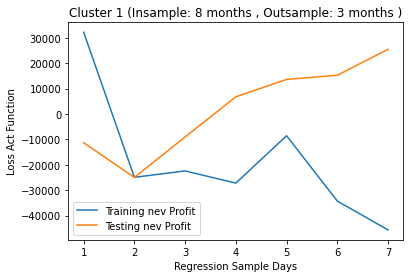

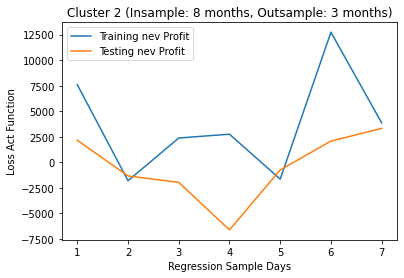

In [ ]:
import matplotlib.pyplot as plt
epochs = len(coin1_train)
x_axis = range(1, epochs+1)
# plot Loss Function sample for best coin under cluster 1.
fig, ax = plt.subplots()
ax.plot(x_axis, coin1_train_loss, label='Training nev Profit')
ax.plot(x_axis, coin1_test_loss, label='Testing nev Profit')
ax.legend()
plt.ylabel('Loss Act Function')
plt.xlabel('Regression Sample Days')
plt.title('Cluster 1 (Insample: 8 months , Outsample: 3 months )')
plt.show()
# plot Loss Function sample for best coin under cluster 1.
fig, ax = plt.subplots()
ax.plot(x_axis, coin2_train_loss, label='Training nev Profit')
ax.plot(x_axis, coin2_test_loss, label='Testing nev Profit')
ax.legend()
plt.ylabel('Loss Act Function')
plt.xlabel('Regression Sample Days')
plt.title('Cluster 2 (Insample: 8 months, Outsample: 3 months)')
plt.show()

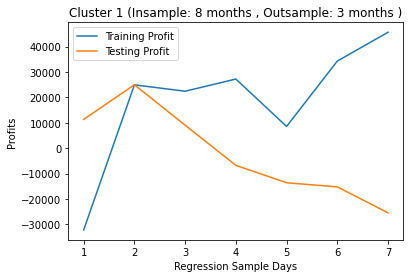

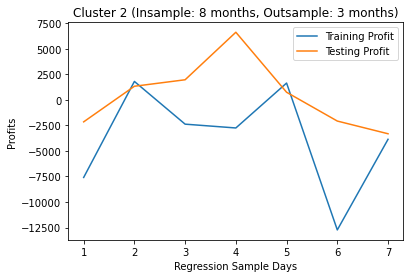

In [ ]:
import matplotlib.pyplot as plt
epochs = len(coin1_train)
x_axis = range(1, epochs+1)
# plot Profits sample for best coin under cluster 1.
fig, ax = plt.subplots()
ax.plot(x_axis, coin1_train, label='Training Profit')
ax.plot(x_axis, coin1_test, label='Testing Profit')
ax.legend()
plt.ylabel('Profits')
plt.xlabel('Regression Sample Days')
plt.title('Cluster 1 (Insample: 8 months , Outsample: 3 months )')
plt.show()
# plot Profits sample for best coin under cluster 1.
fig, ax = plt.subplots()
ax.plot(x_axis, coin2_train, label='Training Profit')
ax.plot(x_axis, coin2_test, label='Testing Profit')
ax.legend()
plt.ylabel('Profits')
plt.xlabel('Regression Sample Days')
plt.title('Cluster 2 (Insample: 8 months, Outsample: 3 months)')
plt.show()

For coin 1 and coin2: Day 2 regression sample is best.


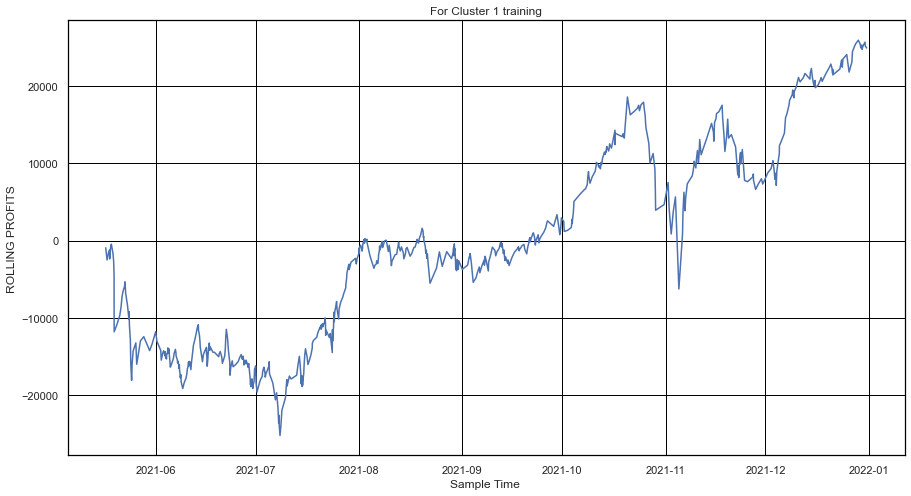

In [ ]:
#sns.set(rc={'axes.facecolor':'white','axes.edgecolor':'black'})
plt.figure(figsize=(15,8))
plt.grid(True,axis='both',which= 'major',color='#000000')
plt.title("For Cluster 1 training")
plt.xlabel("Sample Time ")
plt.ylabel("ROLLING PROFITS")
plt.plot(pnl1_train_time,pnl1_train)

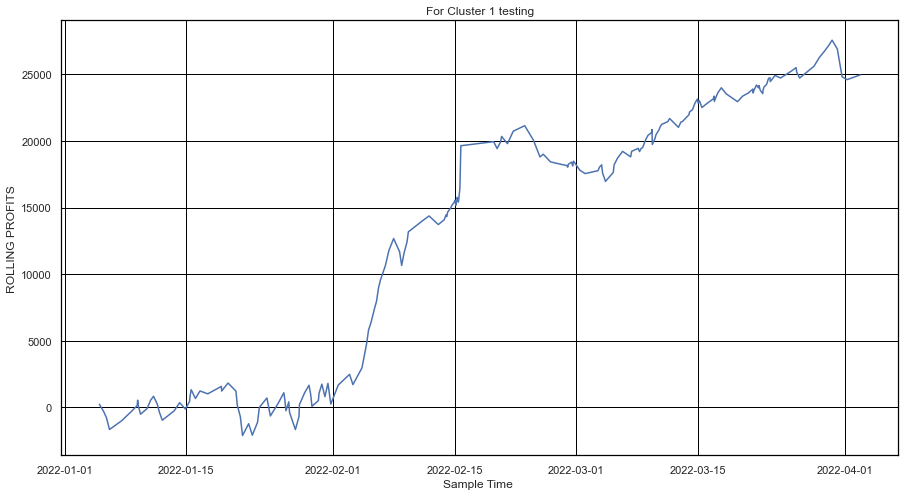

In [ ]:
#sns.set(rc={'axes.facecolor':'white','axes.edgecolor':'black'})
plt.figure(figsize=(15,8))
plt.grid(True,axis='both',which= 'major',color='#000000')
plt.title("For Cluster 1 testing")
plt.xlabel("Sample Time ")
plt.ylabel("ROLLING PROFITS")
plt.plot(pnl1_test_time,pnl1_test)

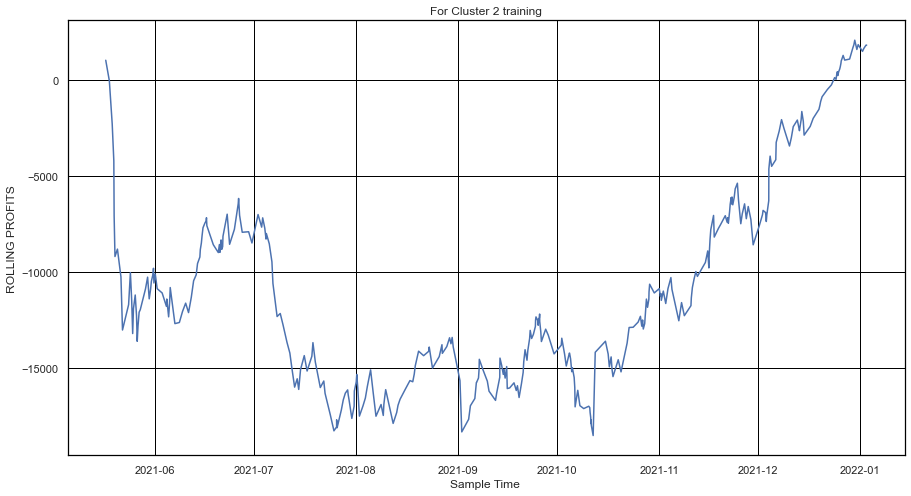

In [ ]:
#sns.set(rc={'axes.facecolor':'white','axes.edgecolor':'black'})
plt.figure(figsize=(15,8))
plt.grid(True,axis='both',which= 'major',color='#000000')
plt.title("For Cluster 2 training")
plt.xlabel("Sample Time ")
plt.ylabel("ROLLING PROFITS")
plt.plot(pnl2_train_time,pnl2_train)

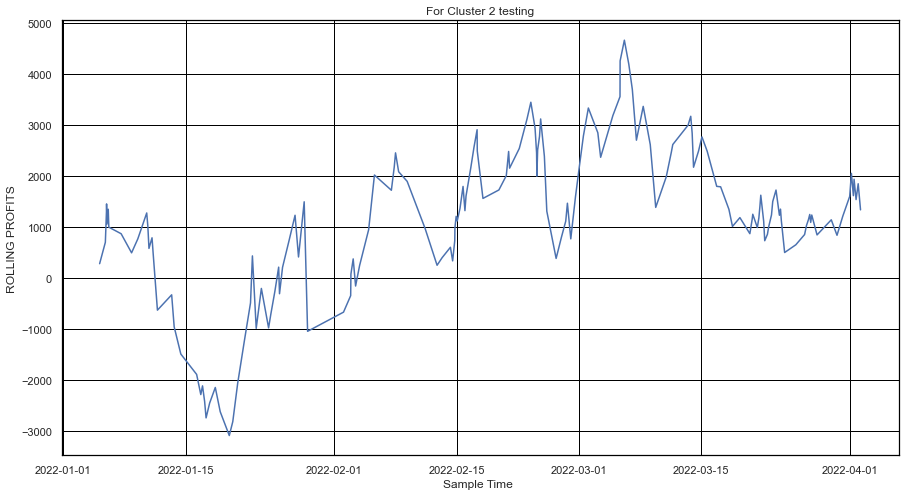

In [ ]:
#sns.set(rc={'axes.facecolor':'white','axes.edgecolor':'black'})
plt.figure(figsize=(15,8))
plt.grid(True,axis='both',which= 'major',color='#000000')
plt.title("For Cluster 2 testing")
plt.xlabel("Sample Time ")
plt.ylabel("ROLLING PROFITS")
plt.plot(pnl2_test_time,pnl2_test)